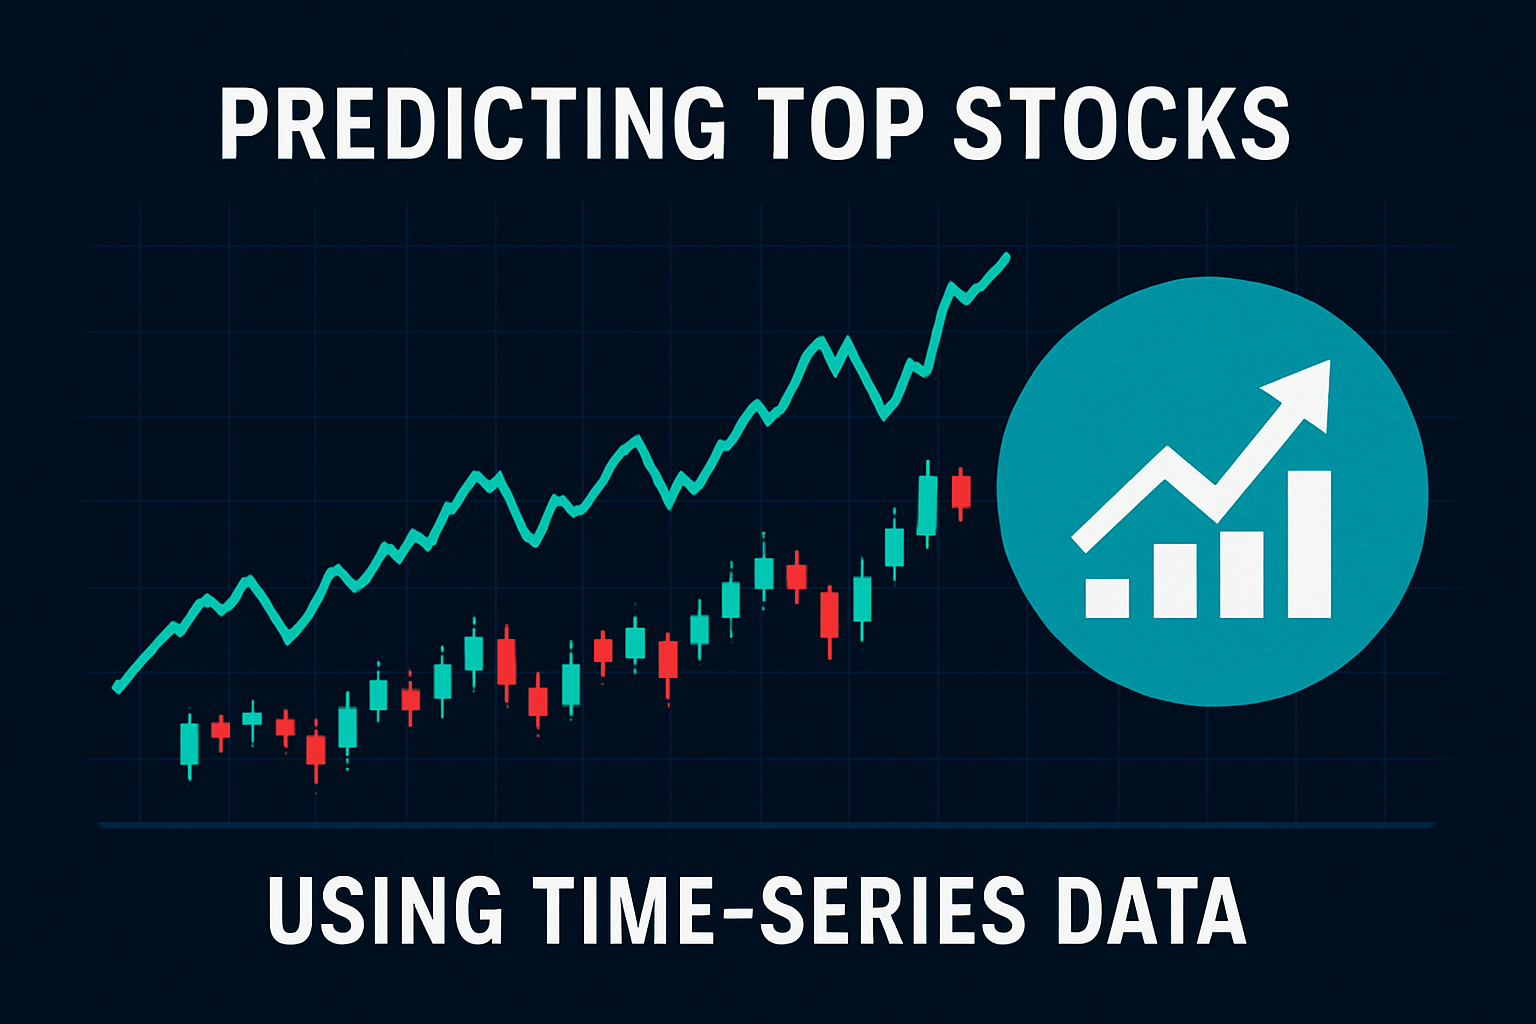

This Python notebook focuses on improving stock price predictions. Building upon the initial Capstone project where a linear regression model predicted the next 7-day stock prices for top US stocks (Tesla (TSLA), Apple (AAPL), Google, and Microsoft (MSFT)) using 5 years of time-series data, this notebook will explore and iteratively improve these predictions. We will achieve this by utilizing more advanced models such as Random Forest, ARIMA, and LSTM.



# 📊  Multi-Model Stock Price Prediction Capstone Project Part2

### 🔎 Project Summary  

This notebook executes a complete code-line for predicting the 7-day **"Adj Close" price for top US stocks (AAPL, GOOG, MSFT, TSLA).** This notebook tries to iteratively improve the predictions baseline from the linear regression model as part of Capstone Project Part1.


1. **THE BASELINE & CHALLENGE: Linear Regression (LR)**  
   The project starts with a **Linear Regression (LR)** model as the baseline. LR model is fast but it relies only on linear relationships and a simple feature set. Its primary
   flaw is being evaluated using a simple 80/20 train/test split, which is unrealistic for real-world time-series data. 

2. **KEY ENHANCEMENTS & METHODOLOGY**

   This notebook features multiple structural and algorithmic improvements designed to maximize **model robustness and prediction accuracy:**


   - A. **Advanced Data Integration:**

       - **Multi-Lag Feature Engineering:** Technical indicators (MA, Volatility, Returns) are calculated across **multiple time windows (5, 20, and 60 days)** to give models both
         short-term and medium-term context.
         
       - **Macro Indicators:** Actual market data for **VIX (volatility)** and
         **SPY(market index)** is integrated as external features.



   - B. **Improved Validation Strategy (Critical Change):**

       - **Walk-Forward Validation (WFV):** The single 80/20 split is replaced. LR, Random Forest (RF), and ARIMA models are retrained every 7 days using all historical data up to             that point, providing the most realistic estimate of true forecast performance.



   - C. **Advanced Models:**

       - **Random Forest (RF):** Captures **non-linear relationships** between the enriched features.

       - **ARIMA (SARIMAX):** Leverages **statistical time-series dependencies** and directly utilizes the Macro indicators.

       - **LSTM (Deep Learning):** Uses a **Stacked, Bidirectional Architecture** with **Early Stopping** to effectively model long-term sequences and prevent overfitting.



   - D. **Observability:**

       - **Feature Importance Plots:** Generated for LR and RF models to provide transparency on which technical/macro features drive the predictions.   

### 📌 Expected Outcomes  

The advanced models (RF, ARIMA, LSTM) are expected to significantly **reduce the RMSE and MAPE** metrics compared to the LR baseline across all four stocks.



In [3]:
# --- REQUIRED PYTHON LIBRARIES ---
# To run this script, install the following packages:
pip install numpy pandas scikit-learn tensorflow keras pmdarima matplotlib seaborn statsmodels

SyntaxError: invalid syntax (1820501614.py, line 3)

In [2]:
pip install "numpy<2.0" --force-reinstall

  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pip

  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import os


In [16]:
# Define the directory to store stock data
DATA_DIR = 'top_usa_stocks_data'

# Define the directory to store final results
RESULTS_DIR = 'results'
# Define the directory for plots
PLOTS_DIR = 'eda_plots' # New directory for plots
# Configuration
STOCK_TICKERS = ['AAPL', 'GOOG', 'MSFT', 'TSLA']
START_DATE  = '2020-09-26'
END_DATE = '2025-09-26'
# NEW: Define multiple look-back windows for feature engineering
LAG_STEPS = [5, 20, 60]
TIME_STEP = max(LAG_STEPS)  # The longest lag defines the overall input window size
FORECAST_HORIZON = 7 # Future days to predict
TARGET_COLUMN = 'Adj Close'## Using Adjusted Close price for better modeling as it accounts for corporate actions like stock splits and dividends.

# Define Macro economic Tickers to download like market volatility index, S&P 500 stocks index. 
MACRO_TICKERS = {
    "VIX": "VIX",
    "SPY": "SPY"
}

In [17]:
# Ensure necessary directories exist
for directory in [DATA_DIR, PLOTS_DIR, RESULTS_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

In [18]:
# Notebook configuration and plot styles
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.style.use("seaborn-v0_8-darkgrid")

**Data Download function**

This function will download 5 years of time-series data for each of the stocks mentioned in the stock_tickers. Our target column is Adjusted closing price which accounts for corporate actions like stock splits and dividends and is the best column for doing prediction.

In [55]:
# Getting the stocks data
def get_stock_data(ticker, start, end):
    """
    Loads stock data from local file ONLY. 
    If file is missing or corrupted, it raises a FileNotFoundError.
    """
    file_path = os.path.join(DATA_DIR, f'{ticker}_{start}_{end}.csv')
    df = None
    
    
    
    # --- HELPER FUNCTION TO FLATTEN COLUMNS ---
    def flatten_columns(df_in):
        if isinstance(df_in.columns, pd.MultiIndex):
            df_in.columns = [' '.join(col).strip() for col in df_in.columns.values]
        return df_in

    if os.path.exists(file_path):
        try:
            # Load from CSV (applying skiprows/header fix for corrupted files)
            df = pd.read_csv(file_path, index_col=0, parse_dates=True, skiprows=1, header=1)
            
            df = flatten_columns(df)
            
            # --- NEW CLEANUP STEP ---
            df = df.dropna(axis=1, how='all')
            df.columns = df.columns.str.strip()

            #print(df.columns)
            
            # --- VALIDATE DATA INTEGRITY ---
            if 'Adj Close' in df.columns:
                df['Close'] = df['Adj Close']
            elif 'Close' in df.columns:
                pass 
            else:
                 # If essential columns are missing after cleaning, the file is unusable
                 raise KeyError(f"Required column 'Adj Close' or 'Close' missing after local load.")

            if df.empty:
                 raise ValueError("Local data file is empty after cleaning.")

            print(f"Loaded {ticker} data from local file.")
            
        except Exception as e:
            # If reading fails, assume cache failure and raise an error
            print(f"FATAL CACHE ERROR: Local stock data file is corrupted or unreadable: {e}")
            raise FileNotFoundError(f"Required file {file_path} is corrupted. Please run download script.")

    else:
        # If file does not exist, raise an error (Must read cache)
        raise FileNotFoundError(f"Required file {file_path} not found. Please run download script first.")
        
    return df

In [54]:
# Getting the Macro Indicators data

def cache_macro_data(macro_name, macro_ticker, start, end):
    """Loads a single macro ticker series from local file ONLY."""
    macro_file_path = os.path.join(DATA_DIR, f'{macro_ticker}_{start}_{end}.csv')
    
    if os.path.exists(macro_file_path):
        try:
            # Load macro data from cache (same header logic as stock data)
            macro_df = pd.read_csv(macro_file_path, index_col=0, parse_dates=True,  header=0 ) ##skiprows=1,)
            macro_df.columns = [col.strip() for col in macro_df.columns.values]

            #print(macro_df.head())
            
            # HANDLE TIME ZONE DIFFERENCES (Required after reading back CSV)
            if macro_df.index.tz is not None:
                macro_df.index = macro_df.index.tz_localize(None)
            

            # We need the 'Close' column from the macro data
            macro_series = macro_df['Close'].rename(macro_name)
            
            print(f"Loaded macro data for {macro_ticker} from local file.")
            return macro_series

        except Exception as e:
            # If local read fails, raise an error
            print(f"FATAL CACHE ERROR: Local macro data file is corrupted or unreadable: {e}")
            raise FileNotFoundError(f"Required file {macro_file_path} is corrupted. Please run download script.")
    else:
        # If file does not exist, raise an error (Must read cache)
        raise FileNotFoundError(f"Required file {macro_file_path} not found. Please run download script first.")


**Function to add Macro economic factors**

The price of a stock is also affected by the other macro economic factors like, market volatility and Overall stock market performance.
The goal of this function is to add external economic factors and integrate them as new features into the main stock price dataset.
It basically downloades macroeconomic indicators (VIX and SPY) and merges them directly into the DataFrame.
By using this function, we enrich the dataset, allowing the Linear Regression model to learn predictive signals not just from the stock's own history, but also from the other   macro economic indicators.

In [21]:
def add_macro_features(df):
    """Reads macro data from cache and merges them into the main DataFrame."""
    print("Reading and merging cached macroeconomic data...")
    
    macro_data = pd.DataFrame(index=df.index) 
    
    for macro_name, macro_ticker in MACRO_TICKERS.items():
        
        # Use the caching function to get the macro series
        macro_series = cache_macro_data(macro_name, macro_ticker, START_DATE, END_DATE)
        
        if macro_series is not None:
            # Merge the series into the master macro_data DataFrame 
            macro_data = macro_data.merge(macro_series, left_index=True, right_index=True, how='left')

            print(f"Successfully processed {macro_ticker}.")
            print("-" * 30)
            
    # Final cleanup before returning (combining all macro data)
    if isinstance(macro_data.columns, pd.MultiIndex):
        macro_data.columns = macro_data.columns.droplevel(-1) 

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(-1) 

    df = df.merge(macro_data, left_index=True, right_index=True, how='left')
    
    # Robust Imputation and Final Drop
    df = df.fillna(method='bfill').fillna(method='ffill').dropna()
    
    return df


**Exploratory Data Analysis and Visualization Function**

This function will perform Exploratory Data Analysis and Visualization of the data.It will do pre-processing and cleaning of data and generate multiple plots to understand the relationship between different features.Its main job is to take the cleaned, feature-enhanced data (that includes VIX and SPY) and visually inspect it to uncover relationships and verify data quality before modeling begins.

In [22]:
# EDA AND VISUALIZATION FUNCTIONS 

# HELPER FUNCTION FOR RELIABLE PLOTTING
def show_and_close_plot(fig, filename):
    """Saves the figure and forces display before closing the figure reference."""
    fig.savefig(filename)
    plt.show()
    print(f"Saved plot: {filename}")
    plt.close(fig) # Explicitly destroys the figure object

# Another helper function for feature importance plotting
def plot_feature_importance(importances, feature_names, ticker, model_name):
    """Generates and saves a horizontal bar chart for feature importance."""
    
    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance and select top 15 features for clarity
    importance_df = importance_df.sort_values(by='Importance', ascending=True).tail(15)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', ax=ax)
    
    # Add context to the plot title
    if model_name == 'LR':
        title = f'{ticker} LR Coefficients (Absolute Magnitude) for 7-Day Forecast'
        ax.set_xlabel('Coefficient Magnitude (Scaled)')
    else:
        title = f'{ticker} RF Feature Importance for 7-Day Forecast'
        ax.set_xlabel('Feature Importance (Gini)')

    ax.set_title(title, fontsize=16)
    
    # --- ENHANCEMENT: Increased padding for aesthetics ---
    fig.tight_layout(pad=2.0)
    
    plot_filename = os.path.join(PLOTS_DIR, f'{ticker}_{model_name.lower()}_feature_importance.png')
    show_and_close_plot(fig, plot_filename)

# Main EDA function
def perform_eda(df, ticker):
    """Inspects data quality and visualizes key metrics, and saves plots."""
    print(f"\n--- EDA for {ticker} ---")
    
    target_col = 'Close'
    
    # A. Data Cleaning: Inspect missing values 
    print("\n[A] Missing Values Inspection (should be zero after ffıll/dropna):")
    # Limiting to top 7 columns
    print(df.isnull().sum().head(7).to_string())

    # B. Calculate Returns for Distribution Analysis
    df['Returns'] = df[target_col].pct_change()
    
    # C. Plotting Prices and Returns Distribution
    # Use Matplotlib's subplots for robust figure handling 
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 5))
    
    # C1. Plotting Prices
    df[target_col].plot(ax=ax1[0], title=f'{ticker} Historical Closing Price')
    ax1[0].set_ylabel('Price (USD)')
    
    # C2. Plotting Returns Distribution (Histogram)
    sns.histplot(df['Returns'].dropna(), bins=50, kde=True, ax=ax1[1])
    ax1[1].set_title(f'{ticker} Daily Returns Distribution')
    ax1[1].set_xlabel('Daily Return')
    
    # ENHANCEMENT: Increased padding for aesthetics
    fig1.tight_layout(pad=2.0)
    
    plot_filename = os.path.join(PLOTS_DIR, f'{ticker}_price_and_returns.png')
    show_and_close_plot(fig1, plot_filename)
    
    # D. Correlation Matrix: Stock Prices vs Macro Indicators (Using VIX and SPY)
    # Use Matplotlib's subplots for robust figure handling 
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    print("\n[D] Correlation Matrix (Stock Price vs Macro):")
    # Removed SENTIMENT from corr_cols
    corr_cols = [target_col, 'VIX', 'SPY'] 
    stock_macro_corr = df[corr_cols].corr()
    
    sns.heatmap(stock_macro_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax2)
    ax2.set_title(f'{ticker} Price & Macro Correlation', fontsize=16)
    
    # Increased padding for aesthetics 
    fig2.tight_layout(pad=2.0)

    plot_filename = os.path.join(PLOTS_DIR, f'{ticker}_price_macro_correlation.png')
    show_and_close_plot(fig2, plot_filename)

    # E. Correlation Matrix: Stock Returns vs Macro Changes (Using VIX and SPY changes)
    df['VIX_Change'] = df['VIX'].pct_change()
    df['SPY_Change'] = df['SPY'].pct_change() 
    
    print("\n[E] Correlation Matrix (Stock Returns vs Macro Changes/Changes):")
    returns_corr_cols = ['Returns', 'VIX_Change', 'SPY_Change'] 
    returns_corr = df[returns_corr_cols].corr().iloc[1:, 0]
    print(returns_corr.to_string())
    print("-" * 30)

    # F. Comprehensive Correlation Matrix (All Features)
    # Calculate rolling technical features for the full data set to show correlation
    df['MA'] = df[target_col].rolling(window=TIME_STEP).mean()
    df['Volatility'] = df[target_col].rolling(window=TIME_STEP).std()
    
    all_features_corr_cols = [target_col, 'MA', 'Volatility', 'VIX', 'SPY']
    all_features_corr = df[all_features_corr_cols].corr()

    # Use Matplotlib's subplots for robust figure handling
    fig3, ax3 = plt.subplots(figsize=(10, 8))
    print("\n[F] Comprehensive Correlation Matrix (All Features):")
    sns.heatmap(all_features_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax3)
    ax3.set_title(f'{ticker} All Features Correlation (MA, Volatility, Macro)', fontsize=16)
    
    # Increased padding for aesthetics 
    fig3.tight_layout(pad=2.0)

    plot_filename = os.path.join(PLOTS_DIR, f'{ticker}_all_features_correlation.png')
    show_and_close_plot(fig3, plot_filename)
    
    # Clean up temporary EDA columns and return the cleaned data for feature engineering
    df = df.drop(columns=['Returns', 'VIX_Change', 'SPY_Change', 'MA', 'Volatility']).dropna()
    return df



**FEATURE ENGINEERING AND DATA PREPARATION FUNCTION**

The main goal of the function "prepare_features_and_targets" is to convert the time-series DataFrame of daily stock prices and macroeconomic indicators into a precisely structured format (X and y) suitable for training advanced machine learning models (Linear Regression, Random Forest, ARIMA, and LSTM).

- This process is complex because it must handle three different data needs:

    - Classical Models (LR/RF): Need flattened input vectors containing the current value of all multi-lagged technical features.

    - Time-Series Target: The target variable (y) must be a 7-day forecast sequence.

    - LSTM (Deep Learning): Requires a separate, scaled, three-dimensional (3D) sequence array for its input.


Here is the detailed break-down of this function:-

1. Dynamic Technical Feature Calculation
   The function first iterates through the predefined LAG_STEPS (5, 20, and 60 days) to generate multiple technical indicators:

    - Multi-Lag Indicators: For each lag period (L in LAG_STEPS), it calculates three features:

        - Moving Average : The average closing price over the last L days, capturing trend.
        - Returns : The percentage change in price over L days, capturing momentum.
        - Volatilty : The standard deviation of the price over L days, capturing risk.
          

    
2. Defining the final Feature Set
    - It constructs the complete list of features that will serve as input for the LR and RF models (X):

3. Creating Training Samples (Sliding Window Logic)
The function uses a loop that iterates over the data (starting after the longest lag period) to create the X and y pairs:
    - Input X (Features): A vector representing the features of the day prior to the forecast start. It includes the current value of all the calculated multi-lag technical features        and the macro indicators. Since the technical features already embed the past 5, 20, and 60-day context, the input vector for LR/RF remains flat.
    - Target (y): The actual Close price for the next 7 days (FORECAST_HORIZON). This is the multi-step sequence the models must learn to predict.
  
4. LSTM-Specific Preparation
As deep learning models (LSTMs) require inputs to be scaled and structured as a sequence (a 3D array), this final section performs dedicated preparation for the LSTM model:

    - Scaling: It scales the core sequence features (Close, VIX, SPY) to the 0 to 1 range using MinMaxScaler.
    - 3D Reshaping : It converts the scaled data into a 3D array (samples, TIME_STEP (60), features (3)). This structure allows the LSTM to process the entire 60-day history as a   sequential block of input.


In [23]:
def prepare_features_and_targets(data_subset, time_step, forecast_horizon):
    """
    Creates multi-lag features (technical + macro) and the multi-step target.
    This prepares the data (X) and target (y) arrays for training.
    
    Returns:
        X (np.ndarray): Flattened input features for regression/RF.
        y (np.ndarray): Target array.
        X_lstm (np.ndarray): Reshaped input features for LSTM (3D array).
        scaler (MinMaxScaler): Scaler fit on the training data for inverse transform.
        data_clean (pd.DataFrame): Cleaned and engineered DataFrame.
        feature_names (list): List of names for all generated features.
    """
    
    # Target and feature creation
    target_col = 'Close'
    
    # DYNAMIC FEATURE CALCULATION USING LAG_STEPS 
    technical_feature_names = []
    for lag in LAG_STEPS:
        data_subset[f'MA_{lag}'] = data_subset[target_col].rolling(window=lag).mean()
        data_subset[f'Ret_{lag}'] = data_subset[target_col].pct_change(periods=lag)
        data_subset[f'Vol_{lag}'] = data_subset[target_col].rolling(window=lag).std()
        technical_feature_names.extend([f'MA_{lag}', f'Ret_{lag}', f'Vol_{lag}'])
    
    # Drop NaNs resulting from rolling calculations 
    data_subset = data_subset.dropna()
    
    # Construct the list of all features for LR/RF input
    macro_features = ['VIX', 'SPY']
    # The feature vector is just the current day's value for all features
    feature_cols = [target_col] + technical_feature_names + macro_features
    
    print(f"Creating features: Input window={time_step} days, Output window={forecast_horizon} days.")
    
    X, y = [], []
    for i in range(time_step, len(data_subset) - forecast_horizon + 1):
        # X: Features for the current day (i-1)
        # This input vector contains all multi-lagged technical features + macro features
        input_vector = data_subset[feature_cols].iloc[i-1].values.flatten()
        X.append(input_vector)
        
        # y: 'Close' price for the next FORECAST_HORIZON days
        target_window = data_subset[target_col].iloc[i:i + forecast_horizon].values
        y.append(target_window)
        
    X = np.array(X)
    y = np.array(y)
    
    # LSTM SPECIFIC PREPARATION 
    lstm_sequence_cols = [target_col, 'VIX', 'SPY']

    # 1. Scale the entire dataset (for LSTM only)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_subset[lstm_sequence_cols].values)
    
    # 2. Create LSTM sequences 
    X_lstm, y_lstm = [], []
    for i in range(time_step, len(scaled_data) - forecast_horizon + 1):
        # X_lstm: 3D Array [samples, time_steps, features] -> Sequence of past 60 days of [Close, VIX, SPY]
        X_lstm.append(scaled_data[i-time_step:i, :])
        # y_lstm: Target array  -> Next 7 days of Close price 
        y_lstm.append(scaled_data[i:i + forecast_horizon, 0]) 
        
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    
    return X, y, X_lstm, y_lstm, scaler, data_subset, feature_cols

**FUNCTIONs FOR MODELING AND EVALUATION**

The MODELING AND EVALUATION FUNCTIONs section of the code contains all the logic for running the models, calculating performance metrics, and preparing the data necessary for the sophisticated **Walk-Forward Validation (WFV) process**.It defines the core evaluation metrics (RMSE and MAPE) and includes the essential setup function, get_train_test_sets, which structures the entire dataset into the specific arrays (X, y, XLSTM, etc.) needed for each of the four distinct models (LR, RF, ARIMA, LSTM) before any training begins.

Here is the detailed break-down of these functions:-

1. Evaluation Metrics
These two helper functions provide the standard quantitative measures of model accuracy:

    - mean_absolute_percentage_error(y_true, y_pred): Calculates MAPE (Mean Absolute Percentage Error). This expresses the average error as a percentage of the true price, which is critical for making prediction errors comparable across different stocks or different time periods.

    - evaluate_model(y_true, y_pred): Calculates both the RMSE (Root Mean Squared Error) and the MAPE. It is called immediately after a model makes its predictions to generate the final scores.


2. Data Preparation Setup (get_train_test_sets)
The get_train_test_sets function is the primary data preparation utility for the modeling phase, performing the complicated work of structuring the data for four different models before any training starts.It does the crucial work of replacing the inadequate 80/20 static split with the data structure needed for **Walk-Forward Validation (WFV)**.

This function's main role is to calculate the initial static split and then execute the core prepare_features_and_targets function on those two segments. It packages the resulting complex arrays into a single dictionary (data_sets) that is easy for the **sequential runner functions (like run_lr_baseline or run_lstm_model)** to unpack and use.

3. Plotting and Visualization (plot_single_model_forecast)
This function is responsible for the visual output. It takes the model's final predictions and plots them alongside the actual training and test prices.

    - It handles the complex task of aligning the 7-day predicted segments with the corresponding actual dates on the chart.
    - It prints the final RMSE and MAPE metrics directly onto the plot title for immediate context.
    - It then calls the show_and_close_plot helper function to save the image to the disk.

In [80]:
# MODELING AND EVALUATION FUNCTIONS 

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates Mean Absolute Percentage Error (MAPE)."""
    # Avoid division by zero by setting a small tolerance (epsilon)
    epsilon = np.finfo(np.float64).eps
    return np.mean(np.abs((y_true - y_pred) / np.maximum(epsilon, y_true))) * 100

def evaluate_model(y_true, y_pred):
    """Calculates RMSE and MAPE for model comparison."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape

def get_train_test_sets(data):
    """Splits data into train and test segments, executes feature preparation, and returns all arrays."""
    
    # Determine the start point for the Test Set 
    # We allocate 20% of the total available data for the test set
    test_size = int(len(data) * 0.20)
    
    # The training set is the remainder 
    train_size = len(data) - test_size
    
    # Perform the split 
    train_data_raw = data[:train_size].copy()
    test_data_raw = data[train_size:].copy()

    # Execute feature preparation for training and testing sets
    X_train, y_train, X_train_lstm, y_train_lstm, scaler, train_data_clean, feature_names = prepare_features_and_targets(
        train_data_raw, TIME_STEP, FORECAST_HORIZON
    )
    # For Walk-Forward, we only need the raw data for the test set, as features are rebuilt inside the loop.
    # The 'test_data_raw' DataFrame will be used as the source for the WFV loop.
    
    # Create the ARIMA-specific data set (raw close prices for modeling)
    arima_full_data = data[['Close', 'VIX', 'SPY']].dropna()
    arima_train_data = arima_full_data[:len(train_data_clean)]
    arima_test_data = arima_full_data[len(train_data_clean):] # Full test data for WFV
    
    X_test, y_test, X_test_lstm, y_test_lstm, _, test_data_clean, _ = prepare_features_and_targets(
        test_data_raw, TIME_STEP, FORECAST_HORIZON
    )
 


    return {
        'lr_rf_init': (X_train, y_train, feature_names),
        'lstm_init': (X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, scaler),
        'wfv_source': data, # Full pre-processed data for WFV slicing
        'wfv_start_index': len(train_data_clean), # Start index of the test set *after* initial cleanup
        'arima': (arima_train_data, arima_test_data),
        'plot_data': (train_data_clean, test_data_clean.head(len(y_test) + FORECAST_HORIZON), y_test)
    }

# Forecast plotting function
def plot_single_model_forecast(train_data, test_data, y_test_true, predictions, ticker, model_name, metrics):
    """Plots a single model's forecast vs. actuals."""
    target_col = 'Close'
    
    # Calculate the index where the predictions actually start
    valid_plot_data = test_data.head(len(y_test_true) + FORECAST_HORIZON).copy()
    
    fig = plt.figure(figsize=(16, 8))
    plt.title(f'{model_name} Forecast for {ticker} | RMSE: {metrics[0]:.2f}, MAPE: {metrics[1]:.2f}%', fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(f'Price USD ({TARGET_COLUMN})', fontsize=18)
    
    # Plot Training and Actual Prices
    plt.plot(train_data[target_col], label='Training Data', color='blue', alpha=0.5)
    plt.plot(valid_plot_data.index, valid_plot_data[target_col], label='Actual Prices', color='black', linewidth=2)
    
    # Plotting the 7-day prediction windows
    for i in range(predictions.shape[0]):
        # The forecast starts at the beginning of the actual observation window for that prediction.
        start_date_forecast = valid_plot_data.index[i]
        
        plt.plot(
            pd.date_range(start=start_date_forecast, periods=FORECAST_HORIZON), 
            predictions[i], 
            linestyle='--', 
            color='red',
            alpha=0.5
        )

    plt.legend(['Train', 'Actual', f'7-Day Predictions ({model_name})'], loc='upper left')
    plt.grid(True)
    
    plot_filename = os.path.join(PLOTS_DIR, f'{ticker}_{model_name.lower()}_forecast.png')
    show_and_close_plot(fig, plot_filename)

    return metrics
    
# MODEL RUNNER FUNCTIONS 

def run_wfv_model(model_builder, data_sets, ticker, model_name, feature_names=None):
    """Generic function to run Walk-Forward Validation for LR/RF/LSTM."""
    
    # Setup data structures for WFV
    wfv_source_data = data_sets['wfv_source']
    start_index = data_sets['wfv_start_index']
    
    all_predictions = []
    all_y_true = []
    
    # Total available data points to loop through in the test set
    test_data_end = len(wfv_source_data) - FORECAST_HORIZON
    
    # WFV LOOP 
    for i in range(start_index, test_data_end, FORECAST_HORIZON):
        # DEFINE TRAINING WINDOW: All data up to the current prediction point
        train_window = wfv_source_data.iloc[:i]
        
        # PREPARE FEATURES/TARGETS for the current training window
        X_train, y_train, X_train_lstm, y_train_lstm, scaler, train_data_clean, feat_names = prepare_features_and_targets(
            train_window, TIME_STEP, FORECAST_HORIZON
        )
        
        # Skip if the training window is too small after feature preparation cleanup
        if X_train.shape[0] == 0: continue
        
        # FIT THE MODEL (Retrain on the expanding window)
        if model_name == 'LSTM':
            # LSTM needs specific 3D reshaping
            X_train_fit = X_train_lstm.reshape(X_train_lstm.shape[0], TIME_STEP, X_train_lstm.shape[2])
            model = model_builder(X_train_fit.shape[2]) # Rebuild model structure
            # Use a smaller epoch count for fast retraining in the loop
            model.fit(X_train_fit, y_train_lstm, epochs=1, batch_size=32, verbose=0)
            
            # Prepare X_test for LSTM (3D, scaled)
            X_test_scaled = scaler.transform(wfv_source_data[['Close', 'VIX', 'SPY']].iloc[i-TIME_STEP:i].values)
            X_test_fit = X_test_scaled.reshape(1, TIME_STEP, X_test_scaled.shape[1])
            predictions_scaled = model.predict(X_test_fit, verbose=0)

            # Inverse Transform (Complex process retained from run_lstm_model)
            dummy_pred = np.zeros((1, FORECAST_HORIZON, X_train_fit.shape[2]))
            dummy_pred[:, :, 0] = predictions_scaled
            predictions_reshaped = dummy_pred.reshape(-1, X_train_fit.shape[2])
            predictions_inverse = scaler.inverse_transform(predictions_reshaped)
            forecast = predictions_inverse[:, 0].reshape(1, FORECAST_HORIZON)
            
        else:
            # LR/RF Feature Extraction (Input X is just the vector of features for the prediction day)
            X_test_predict = train_data_clean[feat_names].iloc[-1].values.reshape(1, -1)
            
            # Rebuild and Fit
            model = model_builder()
            model.fit(X_train, y_train)
            forecast = model.predict(X_test_predict)

        # COLLECT TRUE VALUE AND PREDICTION
        y_true_segment = wfv_source_data['Close'].iloc[i:i + FORECAST_HORIZON].values.reshape(1, -1)
        
        all_predictions.append(forecast.flatten())
        all_y_true.append(y_true_segment.flatten())
        
        # Advance the index by the forecast horizon
        

    # 5. EVALUATION AND PLOTTING
    y_true_final = np.array(all_y_true).reshape(-1, FORECAST_HORIZON)
    predictions_final = np.array(all_predictions).reshape(-1, FORECAST_HORIZON)
    
    metrics = evaluate_model(y_true_final, predictions_final)

    # For plotting, we use a single segment of the prediction window corresponding to the test period
    
    # Static data for visualization
    all_data_clean = wfv_source_data
    train_plot = all_data_clean.iloc[:start_index]
    test_plot = all_data_clean.iloc[start_index:]
    
    # Use the full test set targets (y_true_final) for the last WFV segment's prediction path
    y_true_wfv_plot = wfv_source_data['Close'].iloc[start_index:start_index + len(y_true_final)].values
    
    # To simplify WFV plotting, we plot the actual test set prices and the calculated WFV predictions array
    fig = plt.figure(figsize=(16, 8))
    plt.title(f'{model_name} Walk-Forward Validation Forecast for {ticker} | RMSE: {metrics[0]:.2f}, MAPE: {metrics[1]:.2f}%', fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(f'Price USD ({TARGET_COLUMN})', fontsize=18)
    
    # Plot Training and Actual Prices
    plt.plot(train_plot['Close'], label='Training Data', color='blue', alpha=0.5)
    plt.plot(test_plot['Close'], label='Actual Prices', color='black', linewidth=2)
    
    # Plot the WFV predictions (Using only the first prediction segment for a cleaner visual path)
    
    # Create a single line representing the final forecast path (using the start of each prediction segment)
    wfv_plot_index = test_plot.index[::FORECAST_HORIZON][:len(predictions_final)]
    wfv_plot_values = predictions_final[:, 0]
    
    plt.plot(wfv_plot_index, 
             wfv_plot_values, 
             label='WFV Forecast Path', 
             linestyle='--', 
             marker='o',
             color='red', 
             alpha=0.7)
    
    plt.legend(['Train', 'Actual', 'WFV Predictions (Smoothed Start)'], loc='upper left')
    plt.grid(True)
    
    plot_filename = os.path.join(PLOTS_DIR, f'{ticker}_{model_name.lower()}_wfv_forecast.png')
    show_and_close_plot(fig, plot_filename)
    
    return {model_name: metrics} 

def run_lr_baseline(data_sets, ticker):
    """Trains and evaluates the Linear Regression baseline using WFV."""
    
    # Helper function to build the LR model for WFV loop 
    def lr_builder(input_features=None):
        return LinearRegression()
    
    metrics_dict = run_wfv_model(lr_builder, data_sets, ticker, 'LR')
    print(f"LR Baseline WFV RMSE: {metrics_dict['LR'][0]:.2f} | MAPE: {metrics_dict['LR'][1]:.2f}%")
    
    # Plot Feature Importance (Requires separate static calculation on initial train set for consistency)
    (X_train_static, y_train_static, feature_names) = data_sets['lr_rf_init']
    model_static = LinearRegression()
    model_static.fit(X_train_static, y_train_static)
    importance = np.mean(np.abs(model_static.coef_), axis=0) 
    plot_feature_importance(importance, feature_names, ticker, 'LR')
    
    return metrics_dict

def run_rf_model(data_sets, ticker):
    """Trains and evaluates the Random Forest model using WFV."""
    
    # Helper function to build the RF model for WFV loop
    def rf_builder(input_features=None):
        return RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    metrics_dict = run_wfv_model(rf_builder, data_sets, ticker, 'RF')
    print(f"RF Improvement WFV RMSE: {metrics_dict['RF'][0]:.2f} | MAPE: {metrics_dict['RF'][1]:.2f}%")
    
    # Plot Feature Importance (Requires separate static calculation on initial train set for consistency)
    (X_train_static, y_train_static, feature_names) = data_sets['lr_rf_init']
    model_static = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model_static.fit(X_train_static, y_train_static)
    importance = np.mean([tree.feature_importances_ for tree in model_static.estimators_], axis=0)
    plot_feature_importance(importance, feature_names, ticker, 'RF')
    
    return metrics_dict

def run_arima_model(data_sets, ticker):
    """Trains and evaluates the ARIMA time-series model using WFV."""
    
    # Setup data structures for WFV
    (arima_train_data_init, arima_test_data) = data_sets['arima']
    
    all_predictions = []
    all_y_true = []
    
    # Total available data points to loop through in the test set
    test_data_end = len(arima_test_data) - FORECAST_HORIZON
    
    # Initialize the expanding training set with the initial training data
    train_set = arima_train_data_init.copy()
    
    # WFV LOOP 
    for i in range(0, test_data_end, FORECAST_HORIZON):
        
        # Define current window (Adding FORECAST_HORIZON days to the training set)
        current_test_window = arima_test_data.iloc[i:i + FORECAST_HORIZON]
        train_set = pd.concat([train_set, arima_test_data.iloc[i:i + FORECAST_HORIZON]])
        
        # Define target and exogenous data for the current fit
        train_close = train_set['Close']
        train_exog = train_set[['VIX', 'SPY']]
        
        # Check if the required slice goes past the end of the data
        exog_slice_end = i + FORECAST_HORIZON
        if exog_slice_end > len(arima_test_data):
            # This should be prevented by the range check, but as a failsafe:
            exog_slice_end = len(arima_test_data)
        
        # Define prediction date range (the next 7 days after the expanded train set)
        #exog_forecast = arima_test_data[['VIX', 'SPY']].iloc[i + FORECAST_HORIZON: i + 2 * FORECAST_HORIZON]
        exog_forecast = arima_test_data[['VIX', 'SPY']].iloc[i: exog_slice_end]
        
        # FIT SARIMAX (Retrain on the expanding window)
        try:
            model = SARIMAX(train_close,
                            order=(1, 1, 1), 
                            exog=train_exog,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            
            arima_model_fit = model.fit(disp=False)
        except Exception:
            # Simplified fallback for WFV: if SARIMAX fails, we skip this window
            continue
            
        # Predict the next FORECAST_HORIZON steps
        start_index = len(train_close)
        end_index = start_index + FORECAST_HORIZON - 1
        
        forecast_output = arima_model_fit.predict(start=start_index, 
                                                  end=end_index, 
                                                  exog=exog_forecast)
        
        # COLLECT TRUE VALUE AND PREDICTION
        # The true y values are the next 7 days after the prediction starts
        #y_true_segment = arima_test_data['Close'].iloc[i + FORECAST_HORIZON : i + 2 * FORECAST_HORIZON].values.reshape(1, -1)
        y_true_segment = arima_test_data['Close'].iloc[i : i + FORECAST_HORIZON].values.reshape(1, -1)
        
        all_predictions.append(forecast_output.values.flatten())
        all_y_true.append(y_true_segment.flatten())
    
    # EVALUATION AND PLOTTING
    y_true_final = np.array(all_y_true).reshape(-1, FORECAST_HORIZON)
    predictions_final = np.array(all_predictions).reshape(-1, FORECAST_HORIZON)
    
    metrics = evaluate_model(y_true_final, predictions_final)

    # For plotting, use a representative subset of the data
    (train_data_clean, test_data_clean, y_test_true) = data_sets['plot_data']
    
    print(f"ARIMA Improvement WFV RMSE: {metrics[0]:.2f} | MAPE: {metrics[1]:.2f}%")
    # Note: Using y_test_true and test_data_clean here just for plotting convenience
    plot_single_model_forecast(train_data_clean, test_data_clean, y_test_true, predictions_final, ticker, 'ARIMA (WFV)', metrics)
    return {'ARIMA': metrics}


def run_lstm_model(data_sets, ticker):
    """Trains and evaluates the LSTM deep learning model."""
    # LSTM remains on single 80/20 split due to high retraining cost
    (X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, scaler) = data_sets['lstm_init']
    (train_data_clean, test_data_clean, y_test_true) = data_sets['plot_data']
    
    # Reshape for LSTM (3D Input)
    X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], TIME_STEP, X_train_lstm.shape[2])
    X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], TIME_STEP, X_test_lstm.shape[2])
    
    # Build and Train Model (Stacked + Bidirectional)
    model_lstm = Sequential()
    
    # Bidirectional layer (reads sequence both forward and backward)
    model_lstm.add(Bidirectional(LSTM(units=60, return_sequences=True), 
                                input_shape=(TIME_STEP, X_train_lstm.shape[2])))
    model_lstm.add(Dropout(0.3))
    
    # Stacked LSTM layer (for deeper temporal feature extraction)
    model_lstm.add(LSTM(units=60))
    model_lstm.add(Dropout(0.3))
    
    model_lstm.add(Dense(FORECAST_HORIZON)) # Output layer for 7-day forecast
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    
    # Define Early Stopping Callback (stops training if validation loss doesn't improve)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    
    print("  [LSTM] Training Deep Learning Model (Epochs=100 with Early Stopping)...")
    # Training with 10% of the data used for validation
    model_lstm.fit(X_train_lstm, y_train_lstm, 
                   epochs=100, 
                   batch_size=32, 
                   validation_split=0.1, # Use 10% of training data for validation loss monitoring
                   callbacks=[early_stopping], 
                   verbose=0) 
    
    # Predict and Inverse Transform
    predictions_lstm_scaled = model_lstm.predict(X_test_lstm, verbose=0)
    
    # Inverse transform requires reshaping the data to match the scaler's input dimensions
    dummy_pred = np.zeros((predictions_lstm_scaled.shape[0], predictions_lstm_scaled.shape[1], X_train_lstm.shape[2]))
    dummy_pred[:, :, 0] = predictions_lstm_scaled # Place predictions in the 'Close' column
    predictions_lstm_reshaped = dummy_pred.reshape(-1, X_train_lstm.shape[2])
    predictions_lstm_inverse = scaler.inverse_transform(predictions_lstm_reshaped)
    
    # Select only the 'Close' price (index 0) and reshape back to [samples, forecast_horizon]
    predictions = predictions_lstm_inverse[:, 0].reshape(-1, FORECAST_HORIZON)
    
    metrics = evaluate_model(y_test_true, predictions)

    print(f"LSTM Improvement RMSE: {metrics[0]:.2f} | MAPE: {metrics[1]:.2f}%")
    plot_single_model_forecast(train_data_clean, test_data_clean, y_test_true, predictions, ticker, 'LSTM', metrics)
    return {'LSTM': metrics}


--- STARTING FULL STOCK ANALYSIS PIPELINE ---

#####################################################
### PROCESSING FULL WORKFLOW FOR AAPL ###
#####################################################

[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]
Loaded AAPL data from local file.
Reading and merging cached macroeconomic data...
Loaded macro data for VIX from local file.
Successfully processed VIX.
------------------------------
Loaded macro data for SPY from local file.
Successfully processed SPY.
------------------------------

[STEP 2: EDA AND VISUALIZATION]

--- EDA for AAPL ---

[A] Missing Values Inspection (should be zero after ffıll/dropna):
Close     0
High      0
Low       0
Open      0
Volume    0
VIX       0
SPY       0


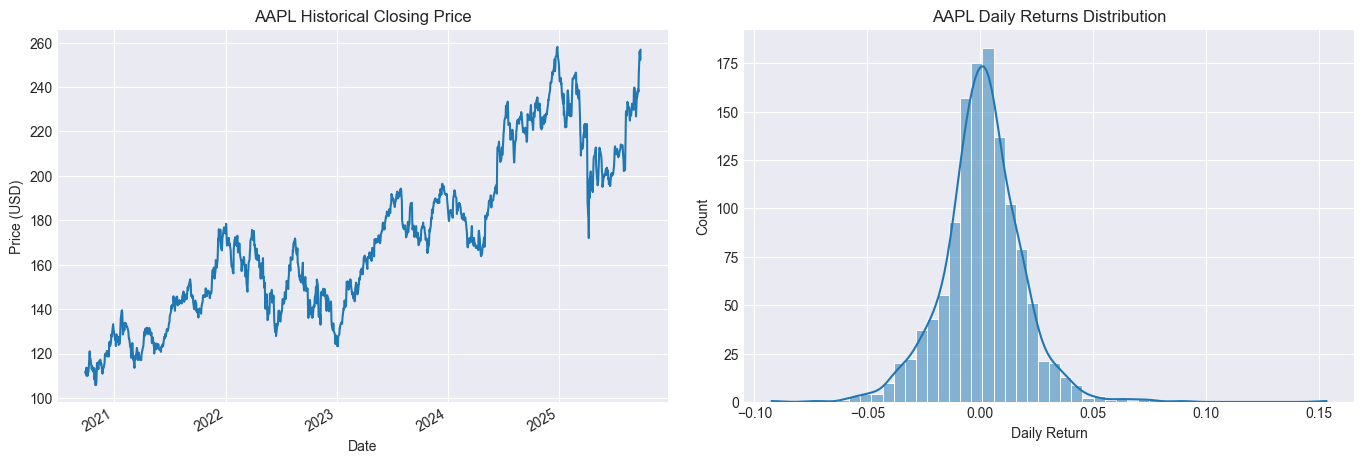

Saved plot: eda_plots/AAPL_price_and_returns.png

[D] Correlation Matrix (Stock Price vs Macro):


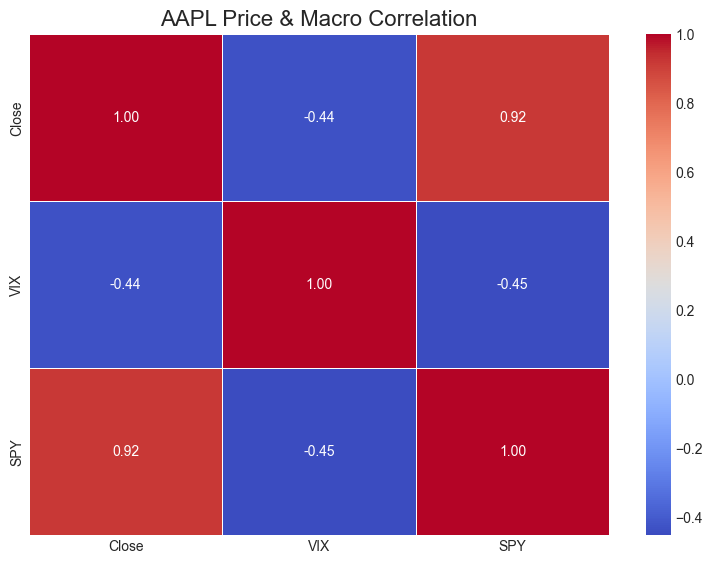

Saved plot: eda_plots/AAPL_price_macro_correlation.png

[E] Correlation Matrix (Stock Returns vs Macro Changes/Changes):
VIX_Change   -0.529390
SPY_Change    0.756528
------------------------------

[F] Comprehensive Correlation Matrix (All Features):


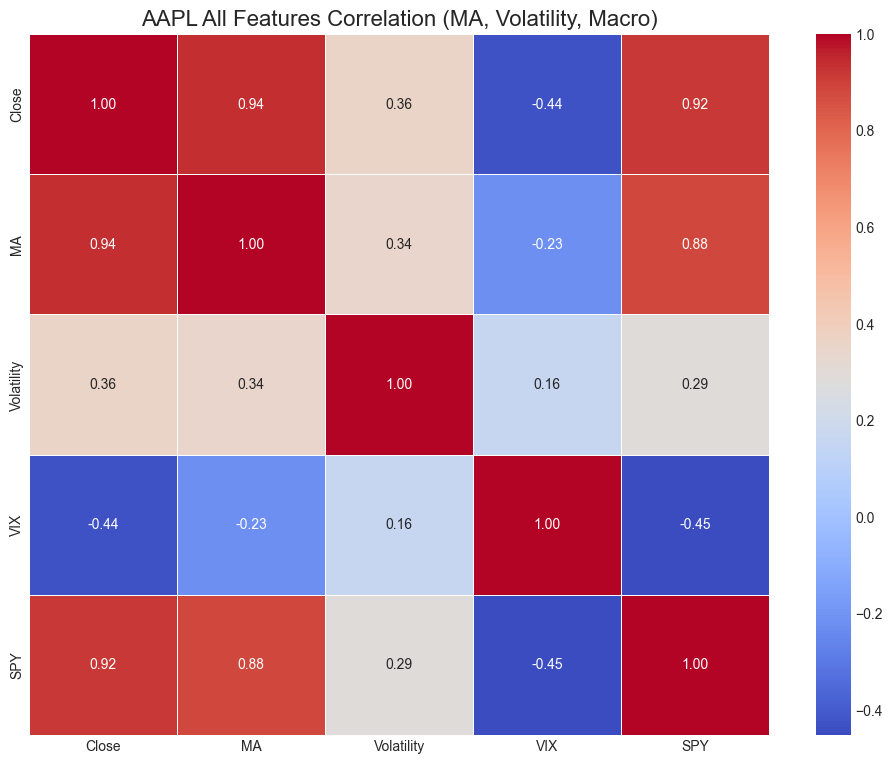

Saved plot: eda_plots/AAPL_all_features_correlation.png

[STEP 3: SEQUENTIAL MODELING AND EVALUATION]
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
dict_keys(['lr_rf_init', 'lstm_init', 'wfv_source', 'wfv_start_index', 'arima', 'plot_data'])

-- 3.1: Running LR Baseline (WFV) --
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating f

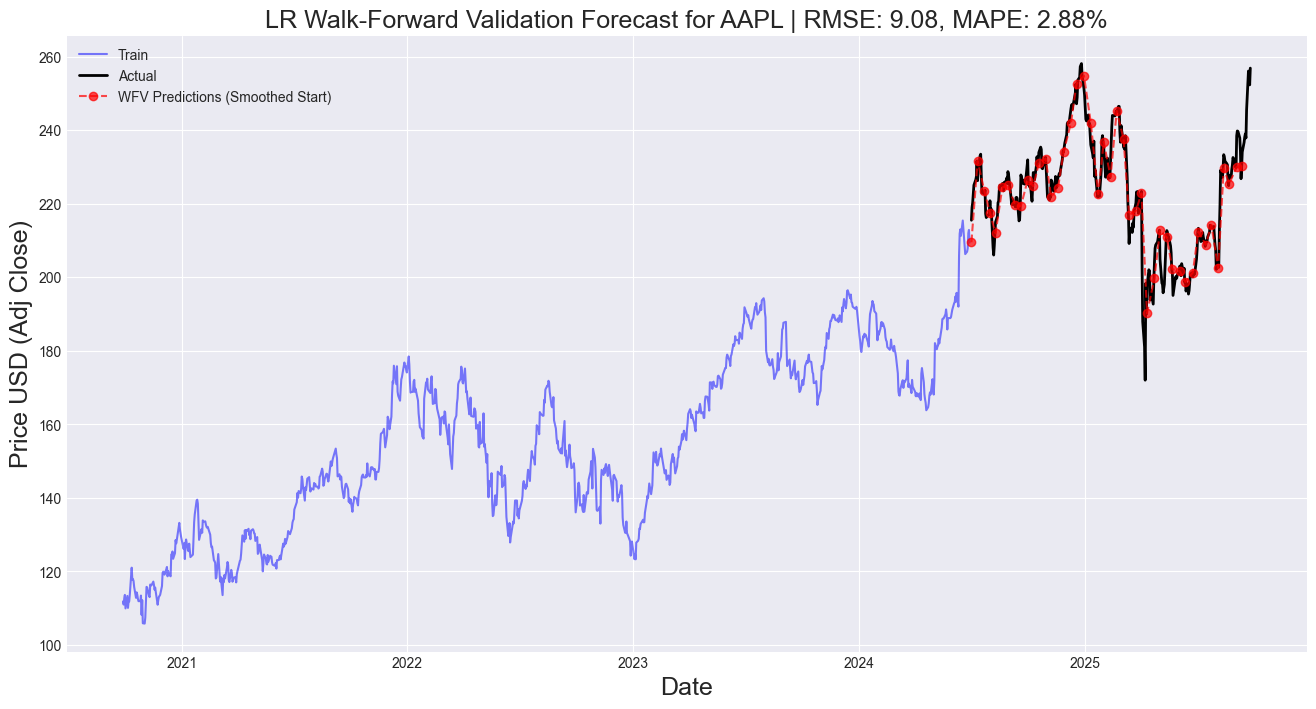

Saved plot: eda_plots/AAPL_lr_wfv_forecast.png
LR Baseline WFV RMSE: 9.08 | MAPE: 2.88%


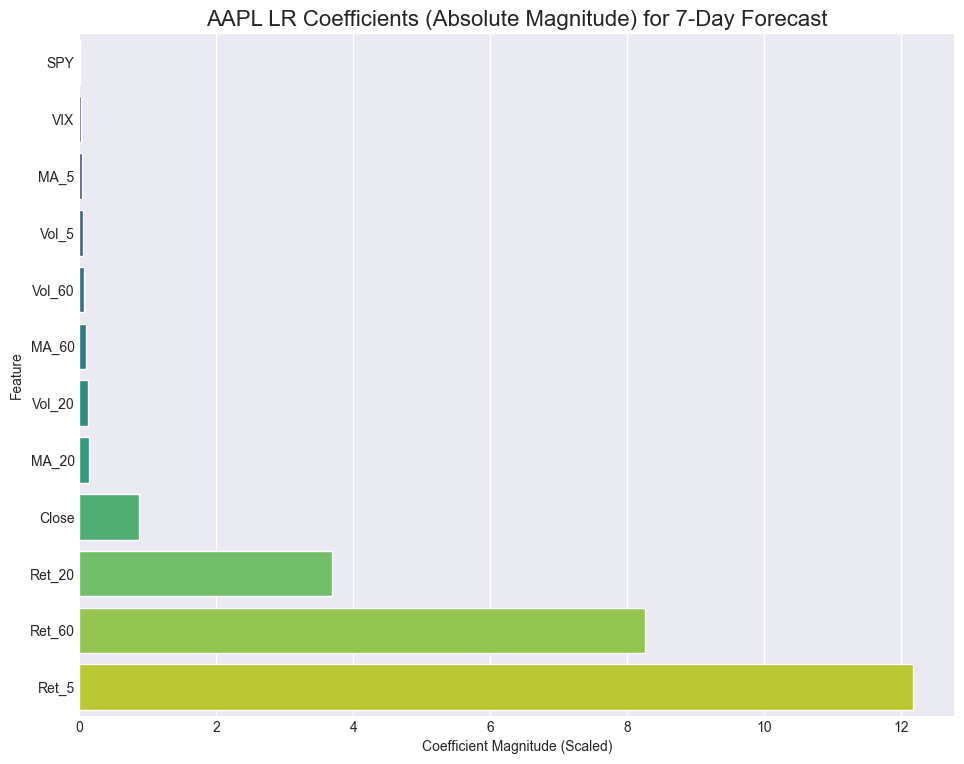

Saved plot: eda_plots/AAPL_lr_feature_importance.png

-- 3.2: Running Random Forest Improvement (WFV) --
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating feat

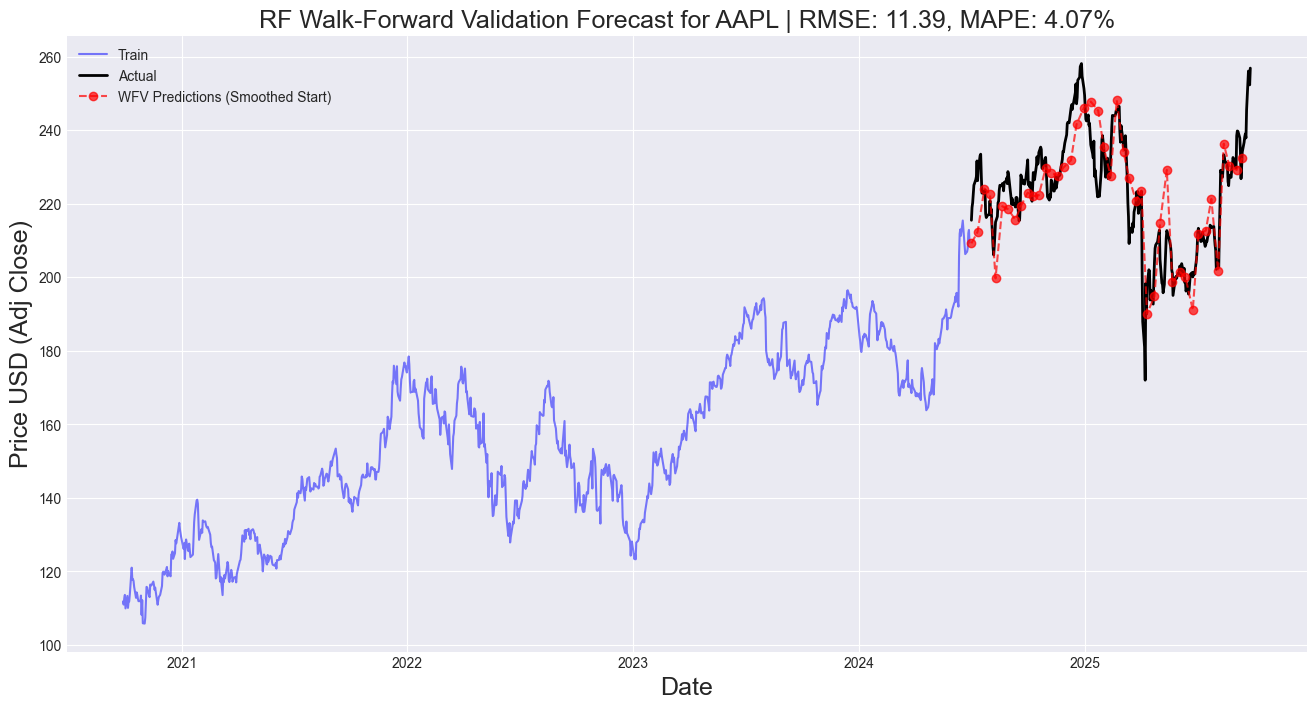

Saved plot: eda_plots/AAPL_rf_wfv_forecast.png
RF Improvement WFV RMSE: 11.39 | MAPE: 4.07%


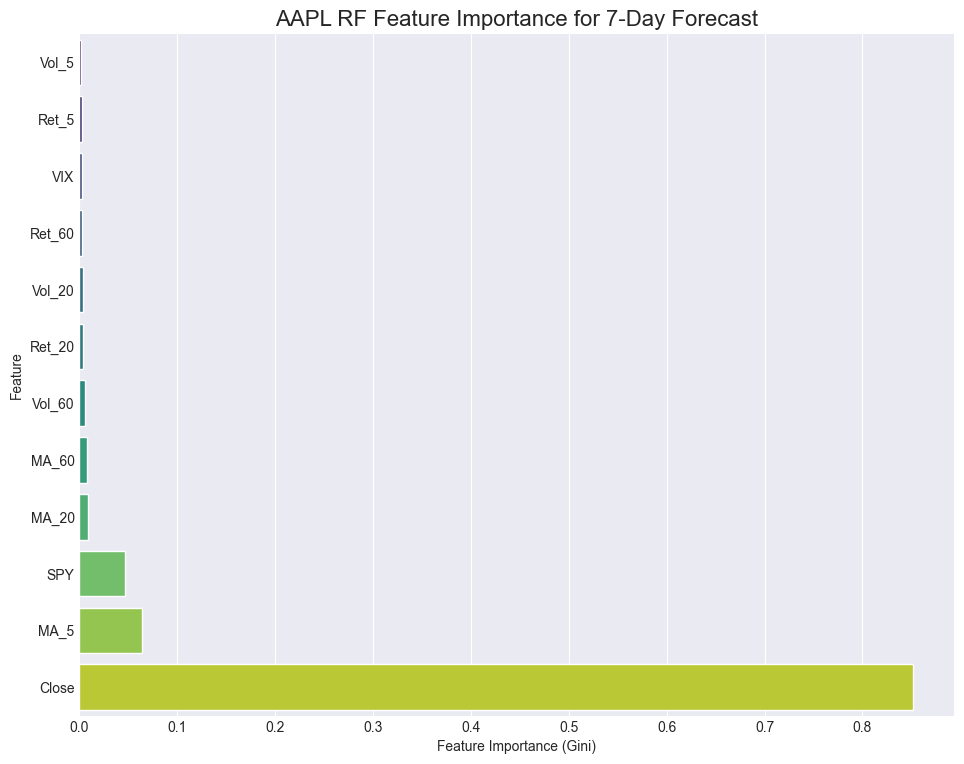

Saved plot: eda_plots/AAPL_rf_feature_importance.png

-- 3.3: Running ARIMA Improvement (WFV) --
ARIMA Improvement WFV RMSE: 5.94 | MAPE: 1.71%


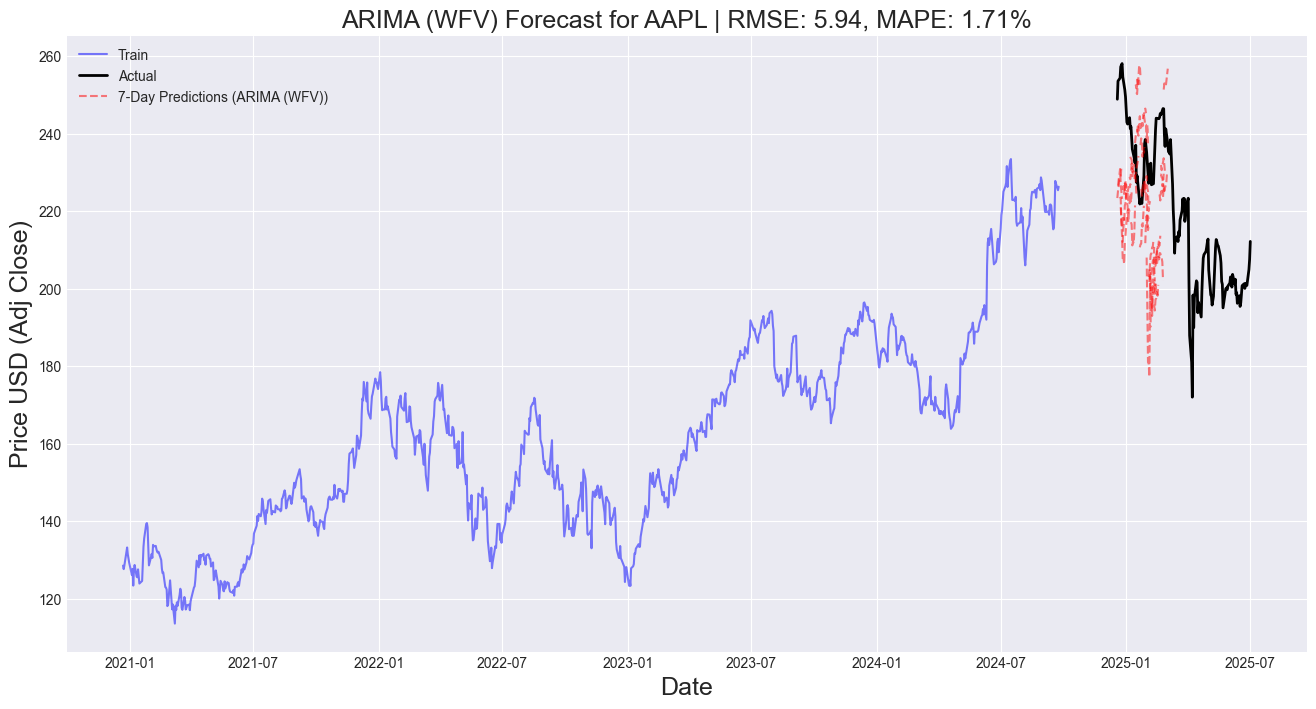

Saved plot: eda_plots/AAPL_arima (wfv)_forecast.png

-- 3.4: Running LSTM Deep Learning Improvement --
  [LSTM] Training Deep Learning Model (Epochs=100 with Early Stopping)...
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
LSTM Improvement RMSE: 43.53 | MAPE: 19.83%


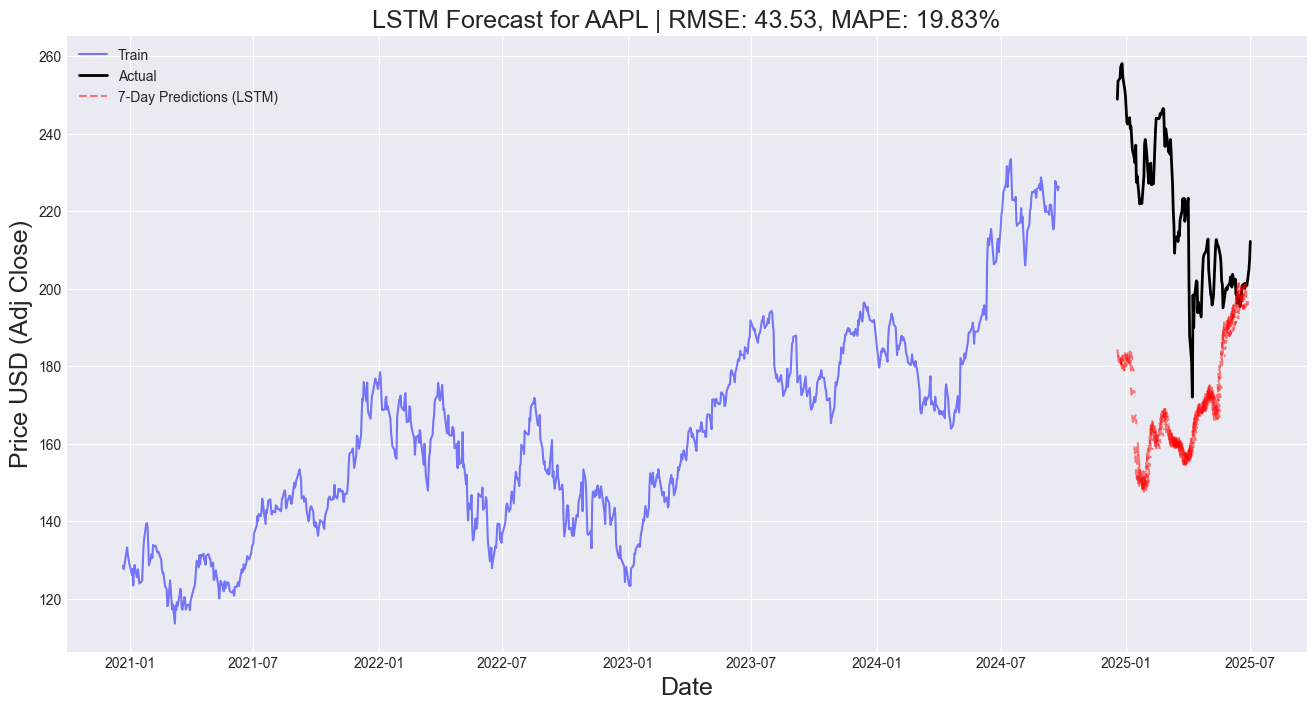

Saved plot: eda_plots/AAPL_lstm_forecast.png
--- AAPL WORKFLOW COMPLETE ---

[STEP 4: SAVING FINAL RESULTS]
All model results saved to: results/multi_model_comparison_results.csv

Final Summary Dashboard saved to: results/final_dashboard.md

Review the final_dashboard.md file for project conclusions.

#####################################################
### PROCESSING FULL WORKFLOW FOR GOOG ###
#####################################################

[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]
Loaded GOOG data from local file.
Reading and merging cached macroeconomic data...
Loaded macro data for VIX from local file.
Successfully processed VIX.
------------------------------
Loaded macro data for SPY from local file.
Successfully processed SPY.
------------------------------

[STEP 2: EDA AND VISUALIZATION]

--- EDA for GOOG ---

[A] Missing Values Inspection (should be zero after ffıll/dropna):
Close     0
High      0
Low       0
Open      0
Volume    0
VIX       0
SPY       

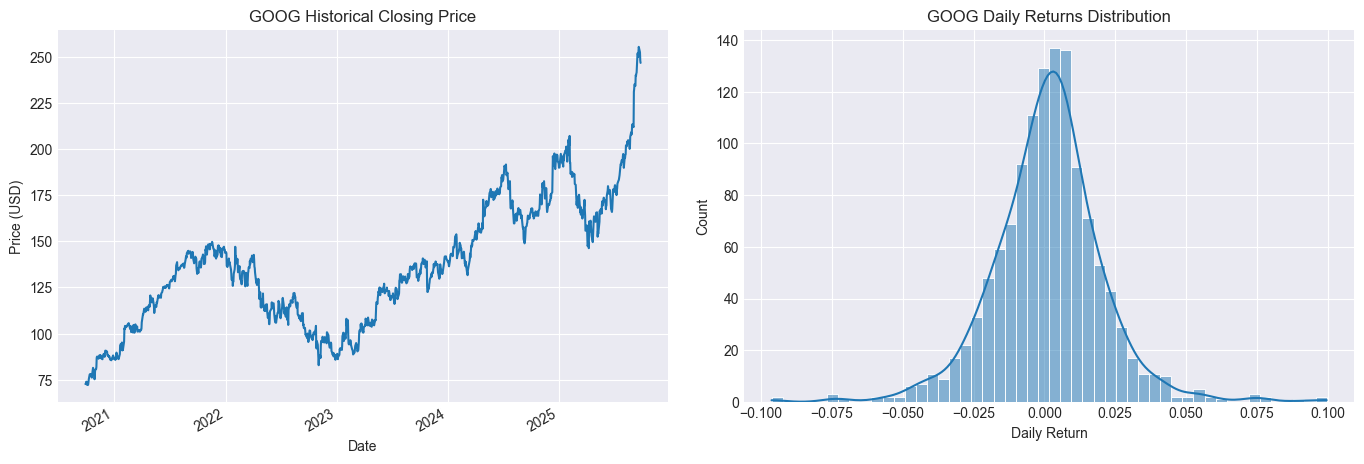

Saved plot: eda_plots/GOOG_price_and_returns.png

[D] Correlation Matrix (Stock Price vs Macro):


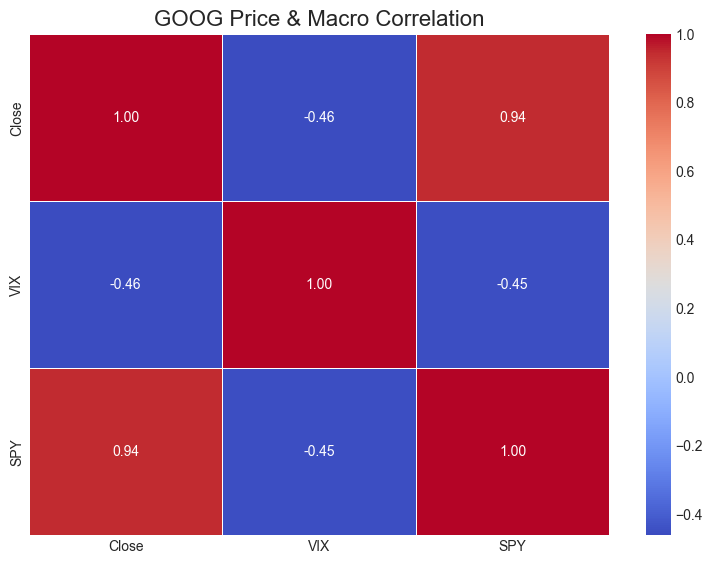

Saved plot: eda_plots/GOOG_price_macro_correlation.png

[E] Correlation Matrix (Stock Returns vs Macro Changes/Changes):
VIX_Change   -0.497710
SPY_Change    0.695684
------------------------------

[F] Comprehensive Correlation Matrix (All Features):


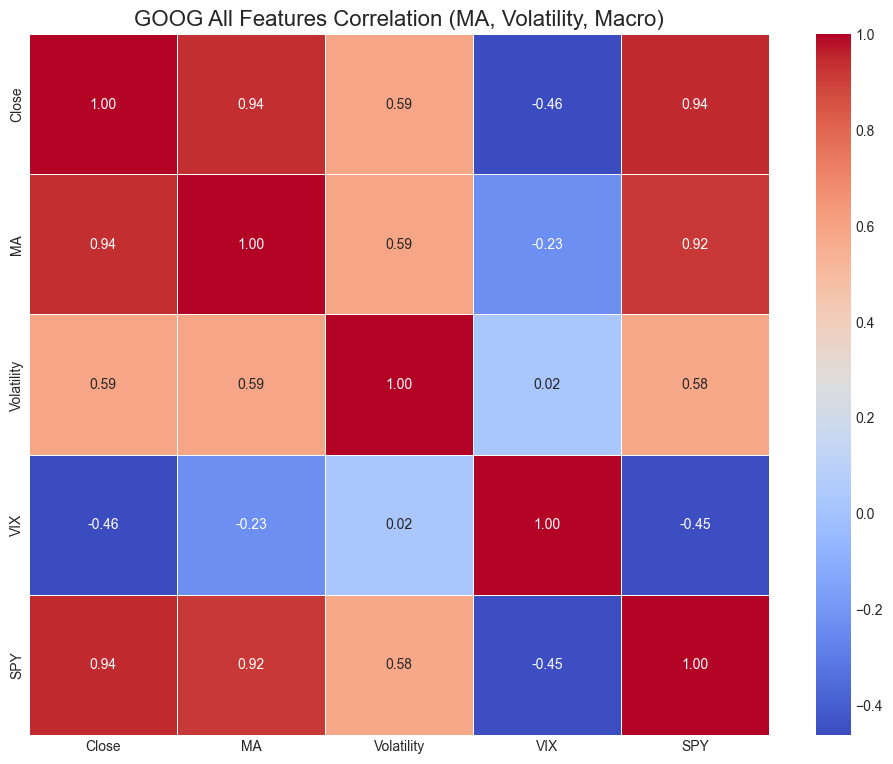

Saved plot: eda_plots/GOOG_all_features_correlation.png

[STEP 3: SEQUENTIAL MODELING AND EVALUATION]
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
dict_keys(['lr_rf_init', 'lstm_init', 'wfv_source', 'wfv_start_index', 'arima', 'plot_data'])

-- 3.1: Running LR Baseline (WFV) --
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating f

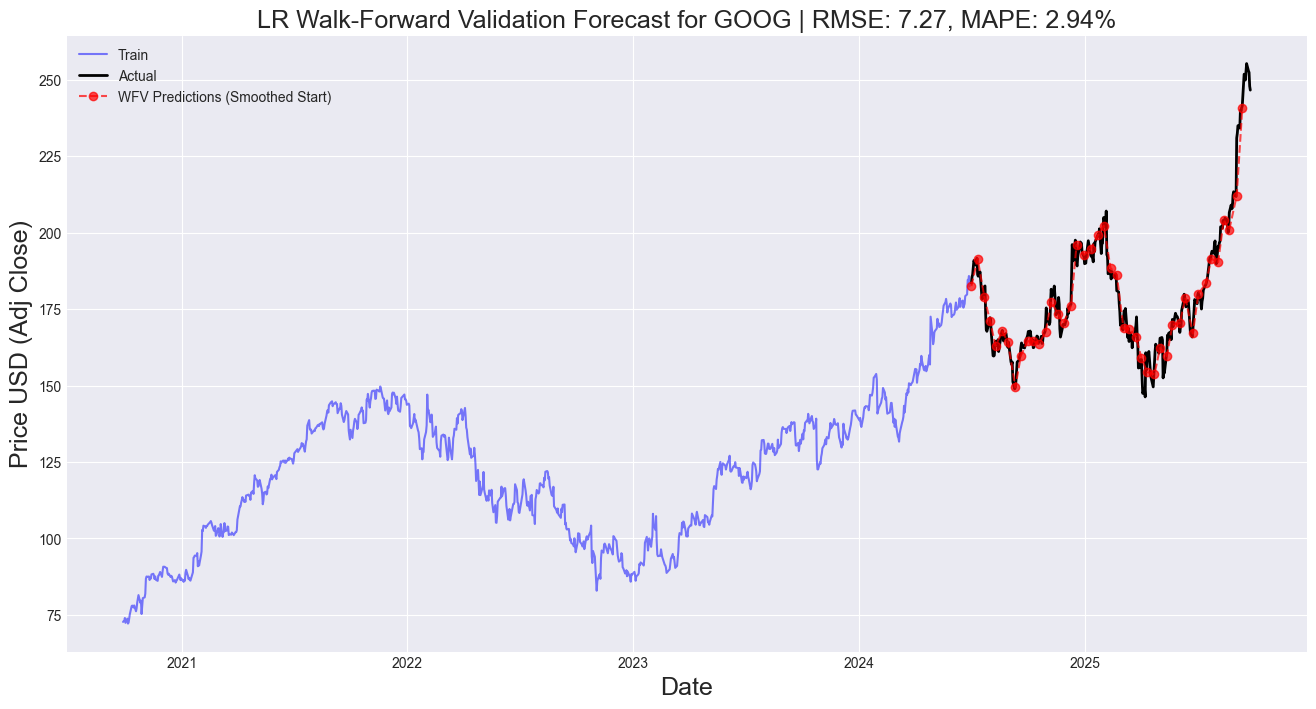

Saved plot: eda_plots/GOOG_lr_wfv_forecast.png
LR Baseline WFV RMSE: 7.27 | MAPE: 2.94%


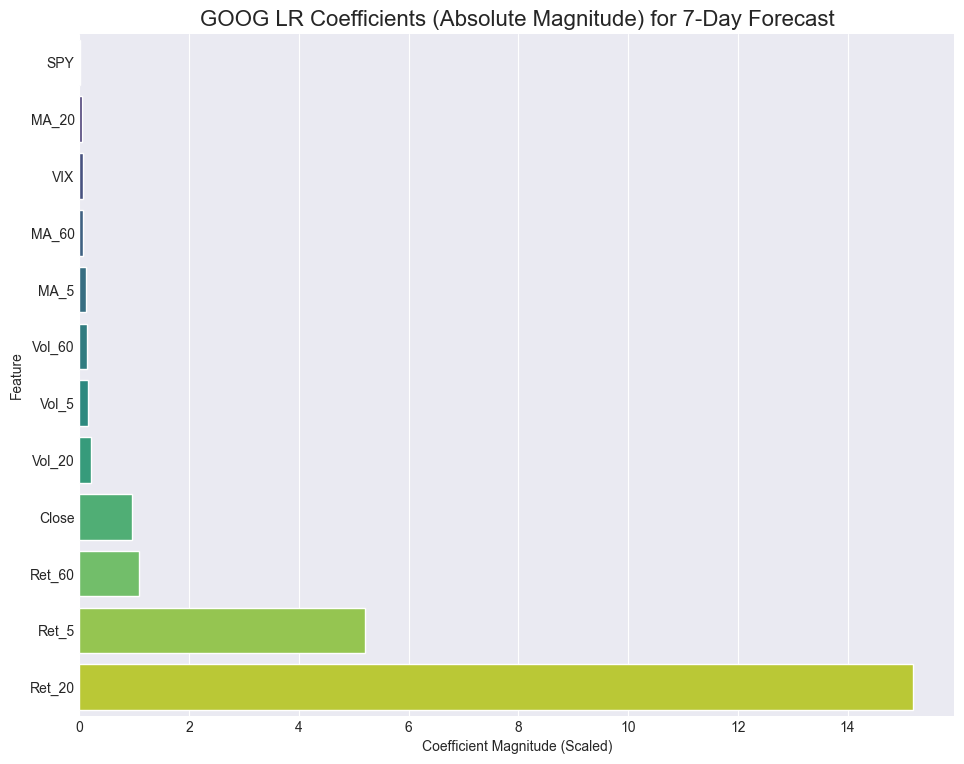

Saved plot: eda_plots/GOOG_lr_feature_importance.png

-- 3.2: Running Random Forest Improvement (WFV) --
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating feat

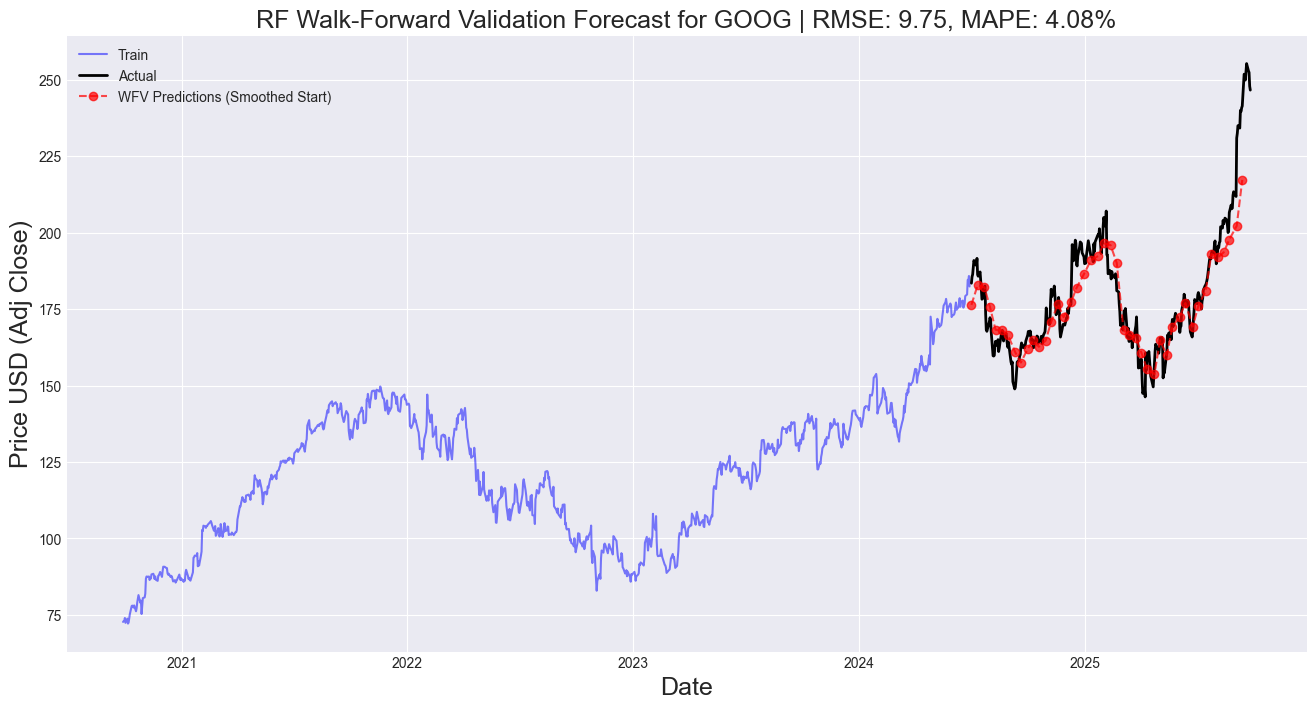

Saved plot: eda_plots/GOOG_rf_wfv_forecast.png
RF Improvement WFV RMSE: 9.75 | MAPE: 4.08%


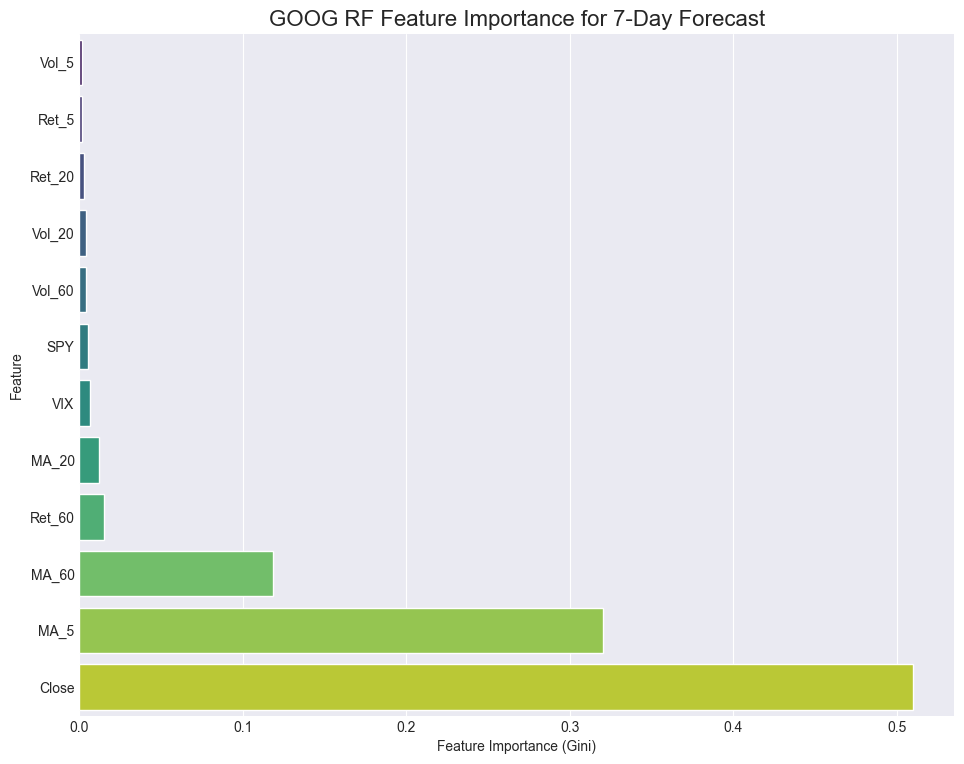

Saved plot: eda_plots/GOOG_rf_feature_importance.png

-- 3.3: Running ARIMA Improvement (WFV) --
ARIMA Improvement WFV RMSE: 4.53 | MAPE: 1.69%


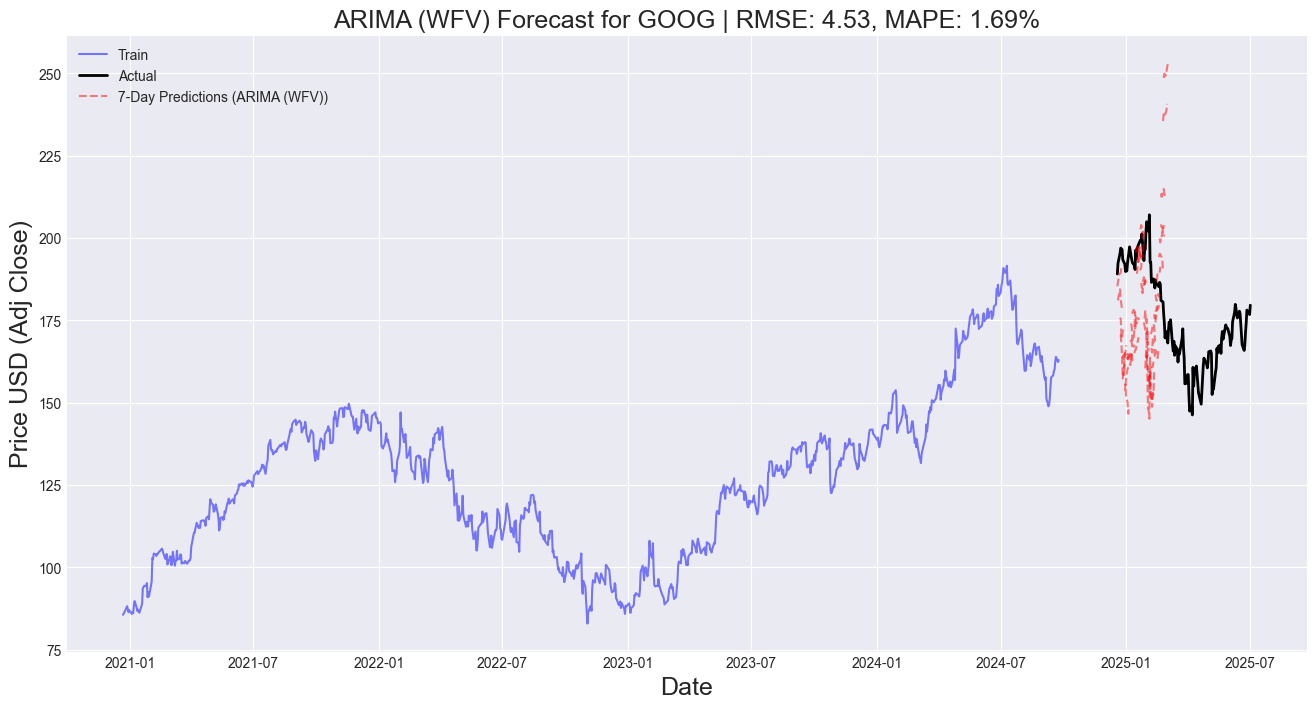

Saved plot: eda_plots/GOOG_arima (wfv)_forecast.png

-- 3.4: Running LSTM Deep Learning Improvement --
  [LSTM] Training Deep Learning Model (Epochs=100 with Early Stopping)...
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 21.
LSTM Improvement RMSE: 66.49 | MAPE: 36.06%


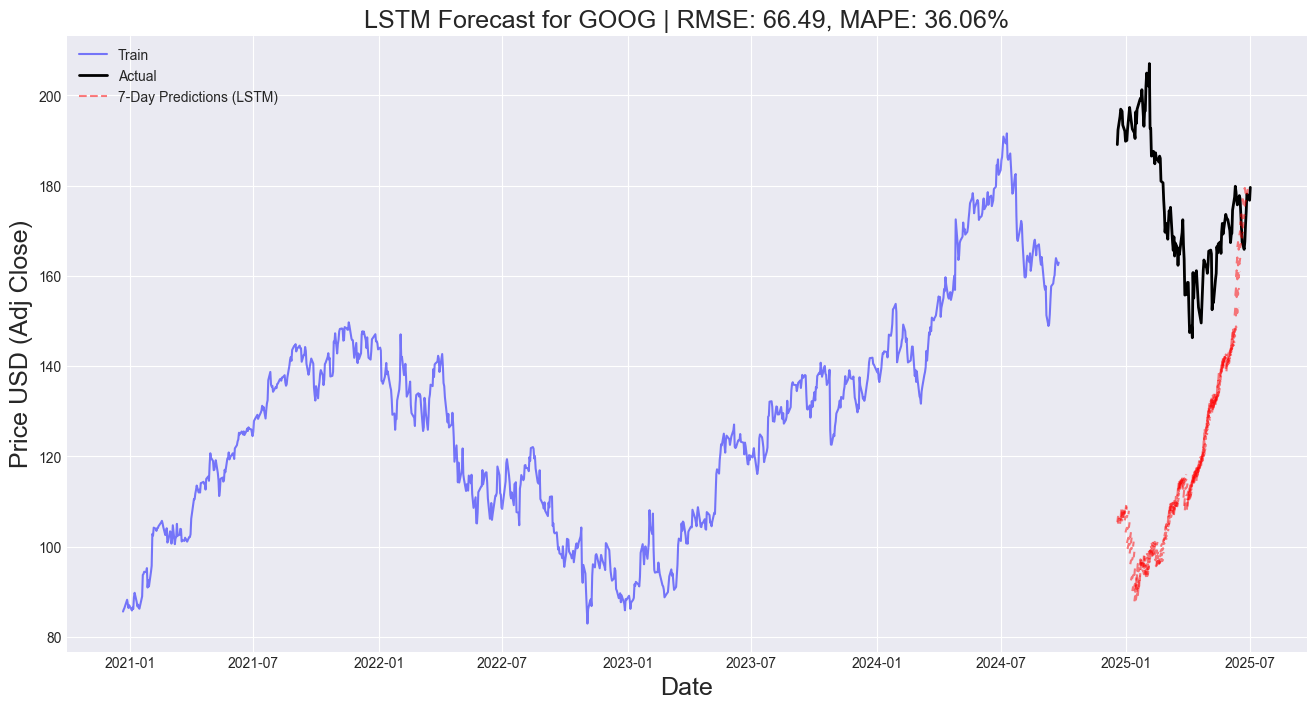

Saved plot: eda_plots/GOOG_lstm_forecast.png
--- GOOG WORKFLOW COMPLETE ---

[STEP 4: SAVING FINAL RESULTS]
All model results saved to: results/multi_model_comparison_results.csv

Final Summary Dashboard saved to: results/final_dashboard.md

Review the final_dashboard.md file for project conclusions.

#####################################################
### PROCESSING FULL WORKFLOW FOR MSFT ###
#####################################################

[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]
Loaded MSFT data from local file.
Reading and merging cached macroeconomic data...
Loaded macro data for VIX from local file.
Successfully processed VIX.
------------------------------
Loaded macro data for SPY from local file.
Successfully processed SPY.
------------------------------

[STEP 2: EDA AND VISUALIZATION]

--- EDA for MSFT ---

[A] Missing Values Inspection (should be zero after ffıll/dropna):
Close     0
High      0
Low       0
Open      0
Volume    0
VIX       0
SPY       

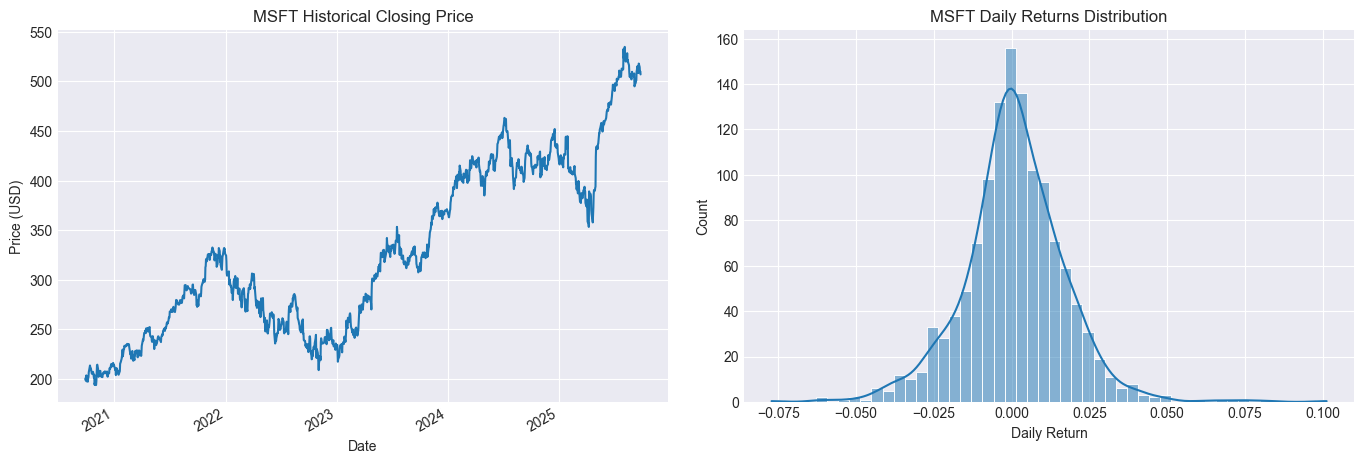

Saved plot: eda_plots/MSFT_price_and_returns.png

[D] Correlation Matrix (Stock Price vs Macro):


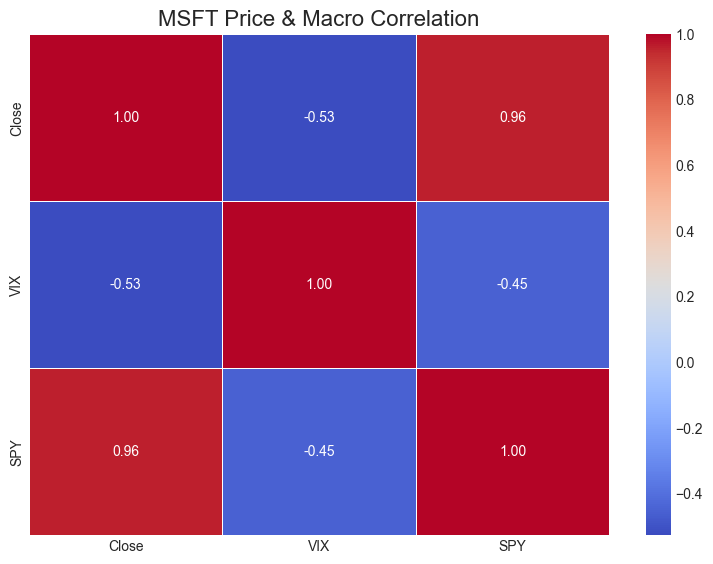

Saved plot: eda_plots/MSFT_price_macro_correlation.png

[E] Correlation Matrix (Stock Returns vs Macro Changes/Changes):
VIX_Change   -0.528299
SPY_Change    0.764408
------------------------------

[F] Comprehensive Correlation Matrix (All Features):


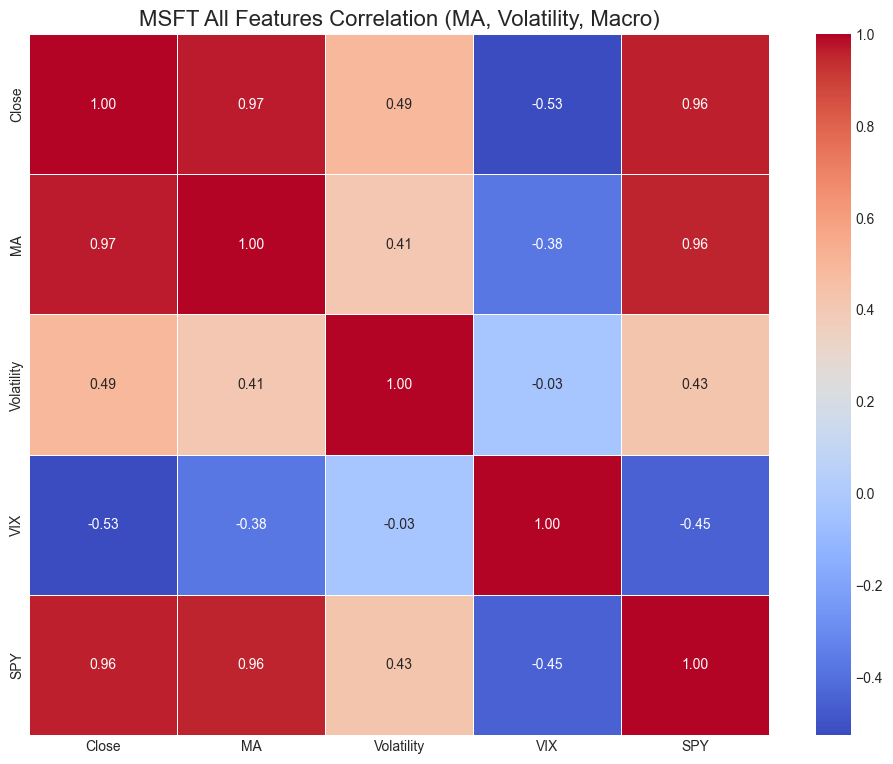

Saved plot: eda_plots/MSFT_all_features_correlation.png

[STEP 3: SEQUENTIAL MODELING AND EVALUATION]
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
dict_keys(['lr_rf_init', 'lstm_init', 'wfv_source', 'wfv_start_index', 'arima', 'plot_data'])

-- 3.1: Running LR Baseline (WFV) --
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating f

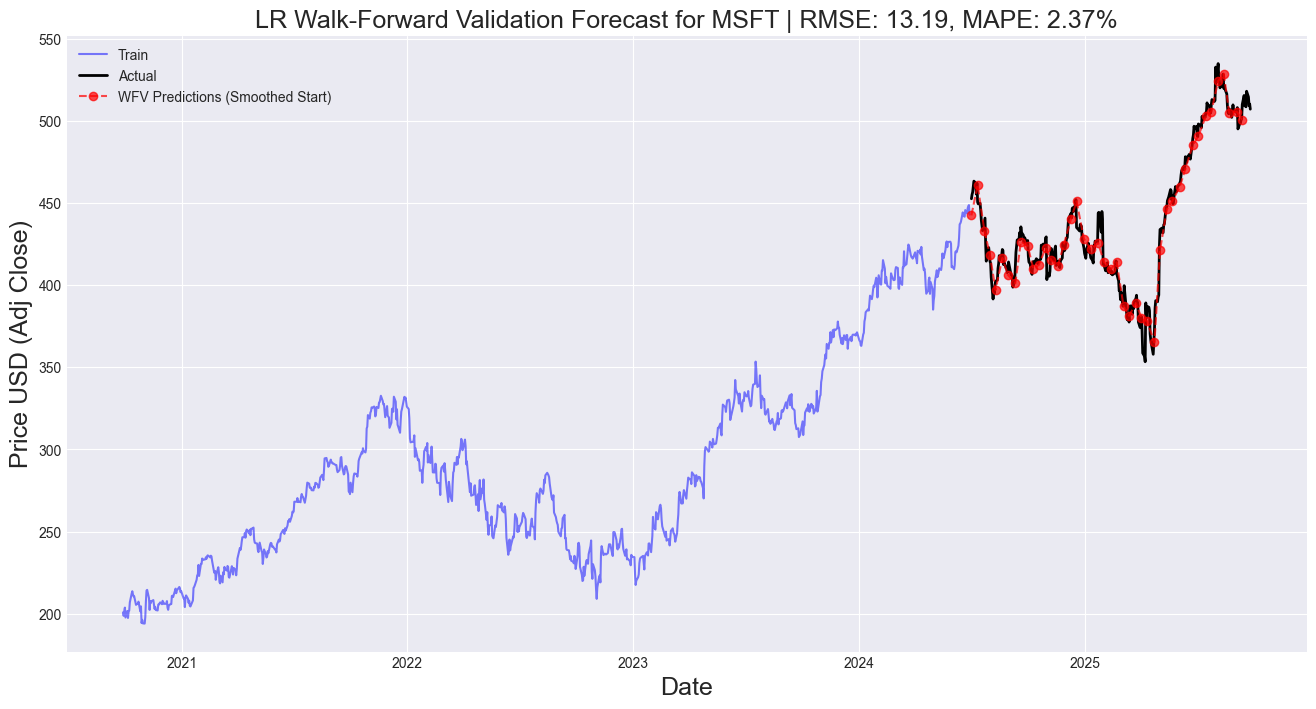

Saved plot: eda_plots/MSFT_lr_wfv_forecast.png
LR Baseline WFV RMSE: 13.19 | MAPE: 2.37%


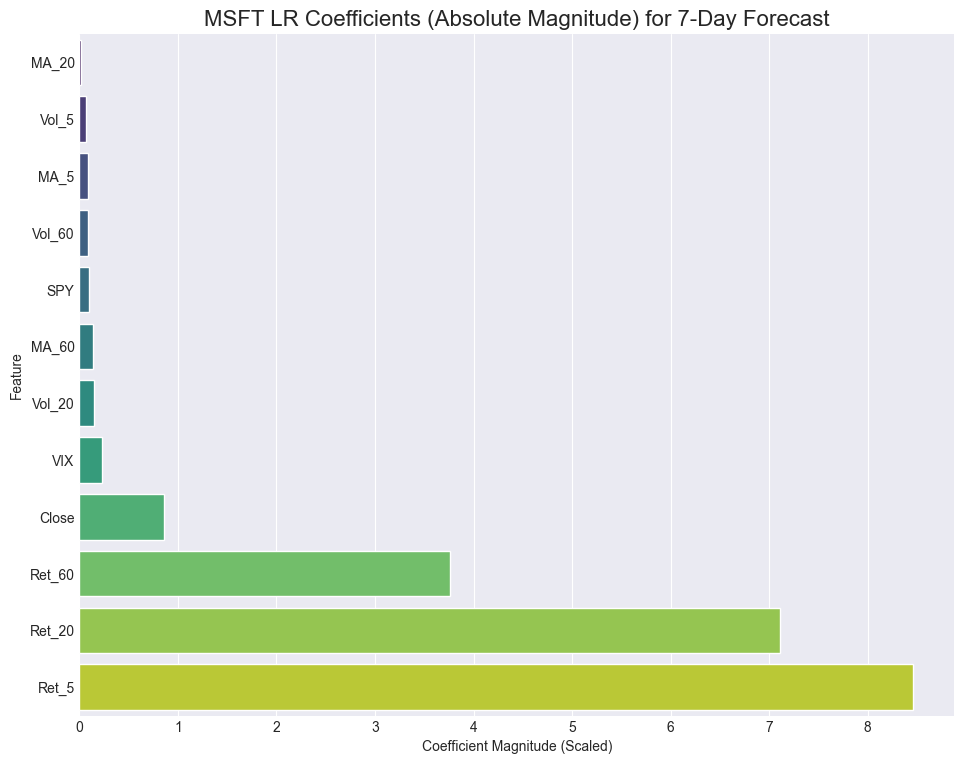

Saved plot: eda_plots/MSFT_lr_feature_importance.png

-- 3.2: Running Random Forest Improvement (WFV) --
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating feat

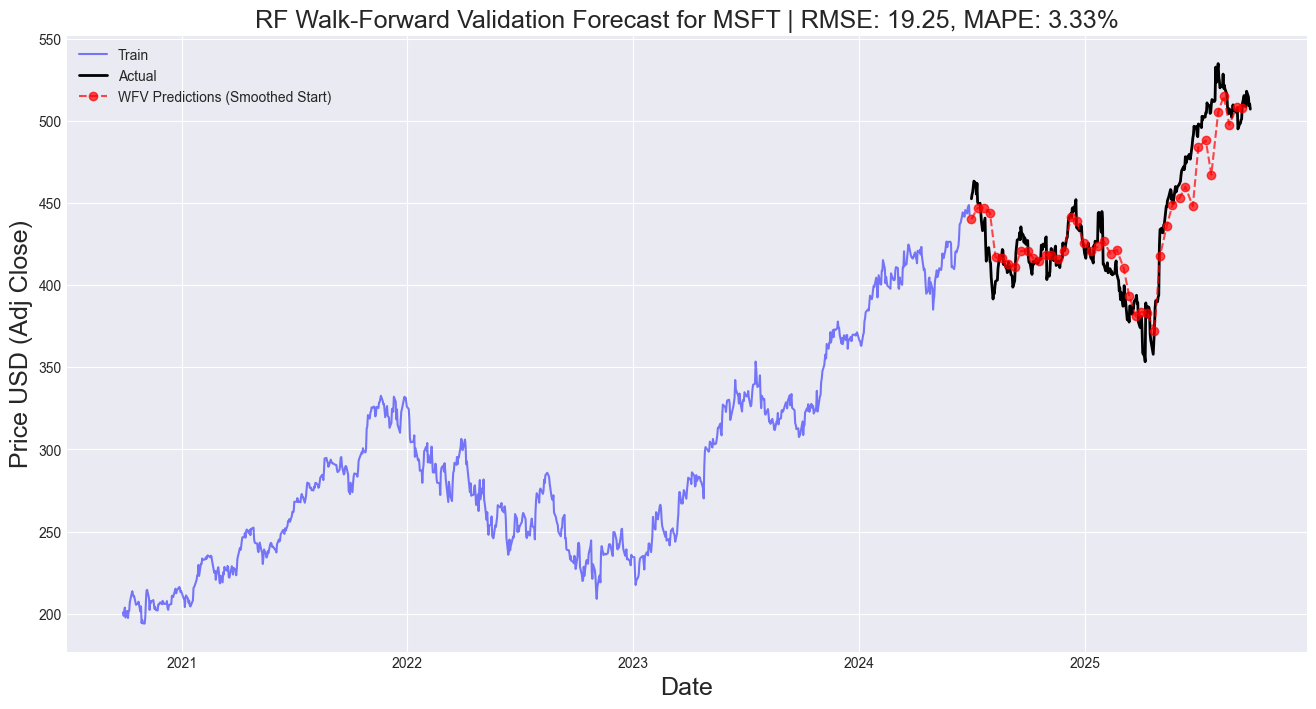

Saved plot: eda_plots/MSFT_rf_wfv_forecast.png
RF Improvement WFV RMSE: 19.25 | MAPE: 3.33%


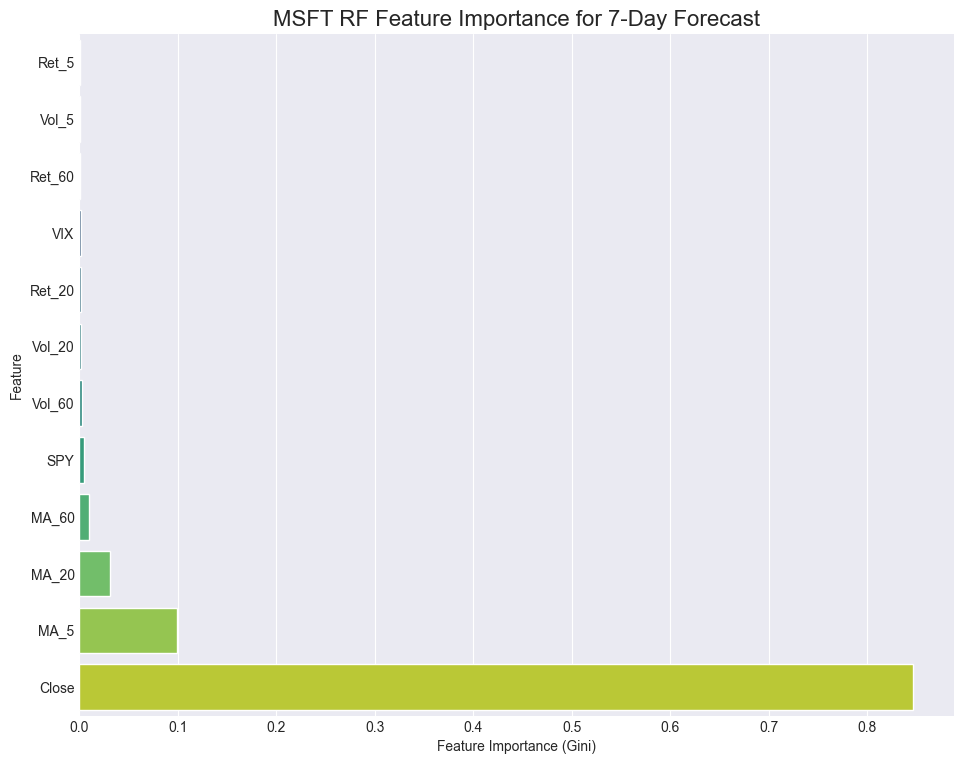

Saved plot: eda_plots/MSFT_rf_feature_importance.png

-- 3.3: Running ARIMA Improvement (WFV) --
ARIMA Improvement WFV RMSE: 8.36 | MAPE: 1.24%


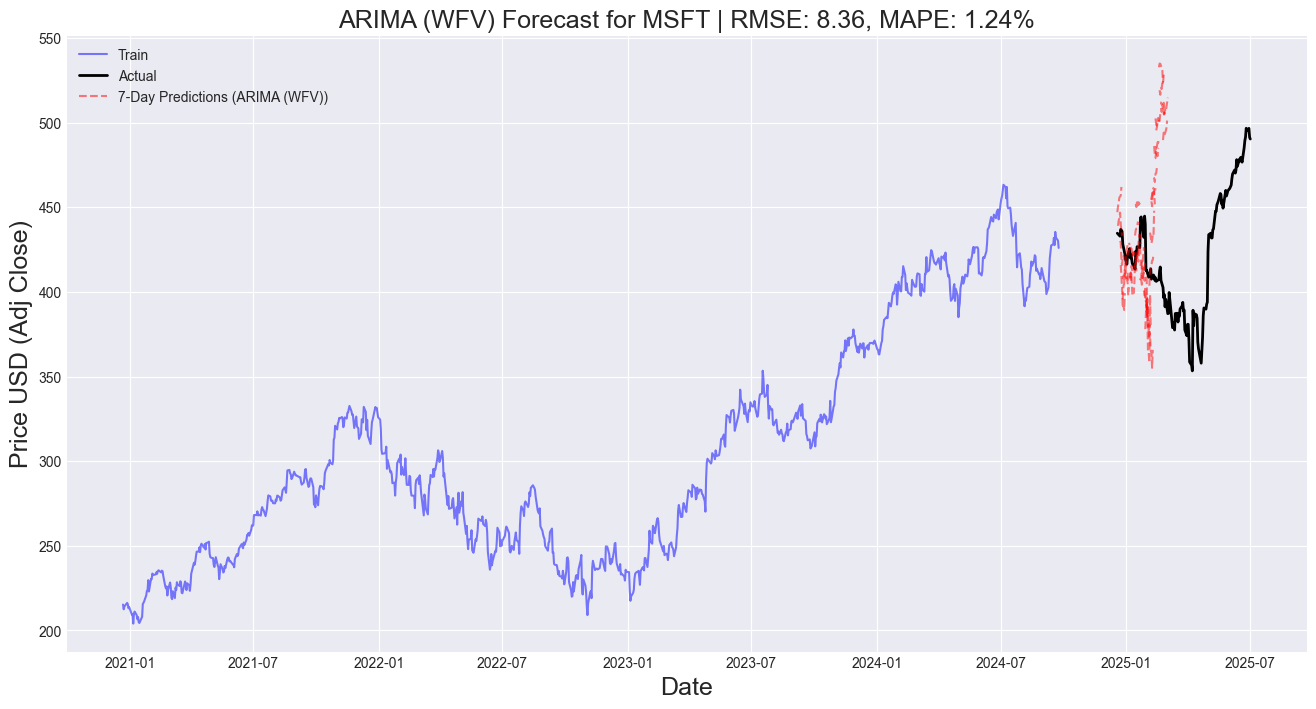

Saved plot: eda_plots/MSFT_arima (wfv)_forecast.png

-- 3.4: Running LSTM Deep Learning Improvement --
  [LSTM] Training Deep Learning Model (Epochs=100 with Early Stopping)...
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.
LSTM Improvement RMSE: 109.94 | MAPE: 23.54%


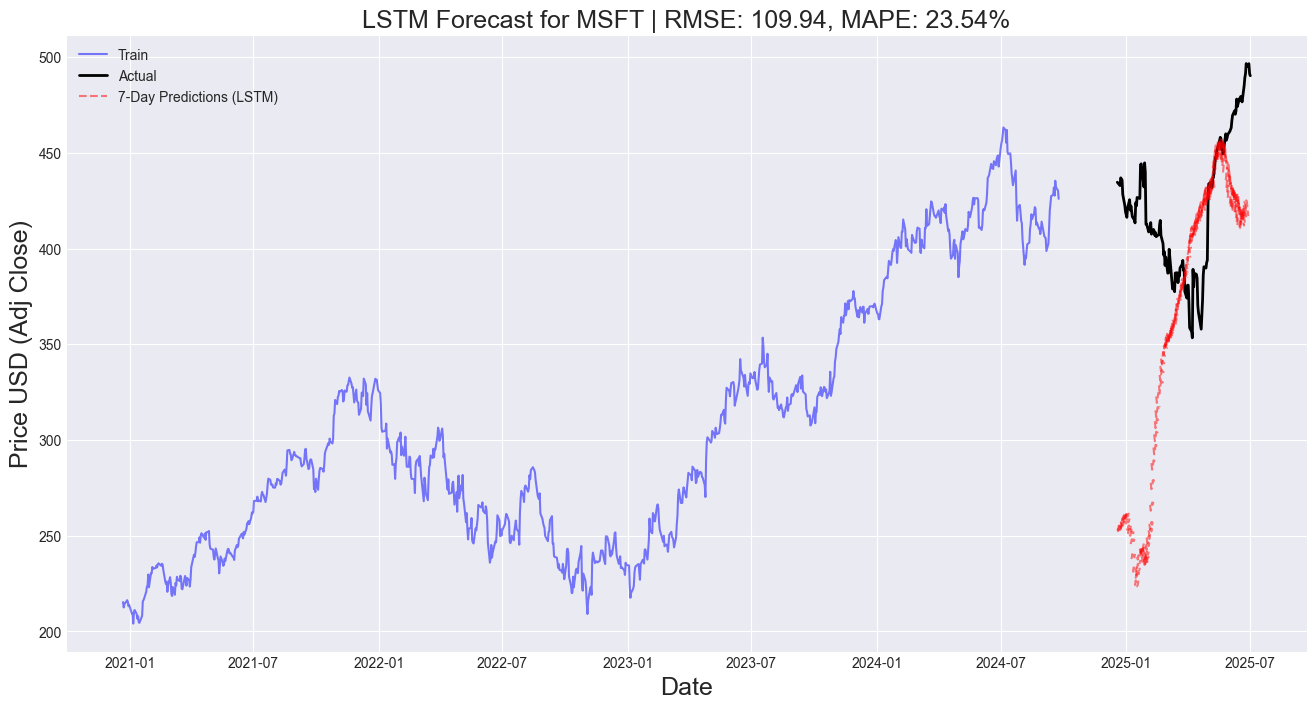

Saved plot: eda_plots/MSFT_lstm_forecast.png
--- MSFT WORKFLOW COMPLETE ---

[STEP 4: SAVING FINAL RESULTS]
All model results saved to: results/multi_model_comparison_results.csv

Final Summary Dashboard saved to: results/final_dashboard.md

Review the final_dashboard.md file for project conclusions.

#####################################################
### PROCESSING FULL WORKFLOW FOR TSLA ###
#####################################################

[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]
Loaded TSLA data from local file.
Reading and merging cached macroeconomic data...
Loaded macro data for VIX from local file.
Successfully processed VIX.
------------------------------
Loaded macro data for SPY from local file.
Successfully processed SPY.
------------------------------

[STEP 2: EDA AND VISUALIZATION]

--- EDA for TSLA ---

[A] Missing Values Inspection (should be zero after ffıll/dropna):
Close     0
High      0
Low       0
Open      0
Volume    0
VIX       0
SPY       

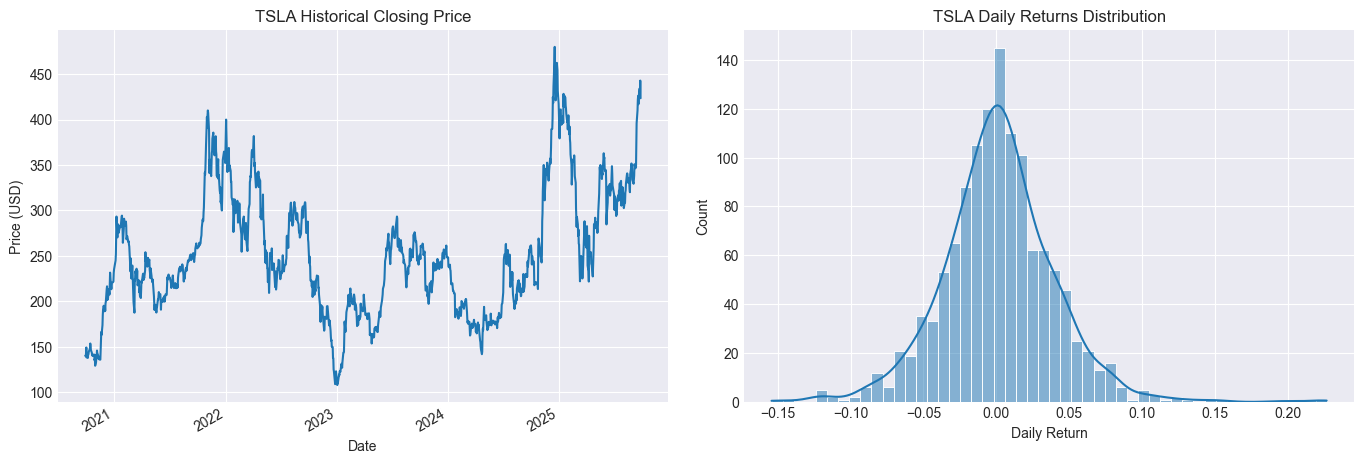

Saved plot: eda_plots/TSLA_price_and_returns.png

[D] Correlation Matrix (Stock Price vs Macro):


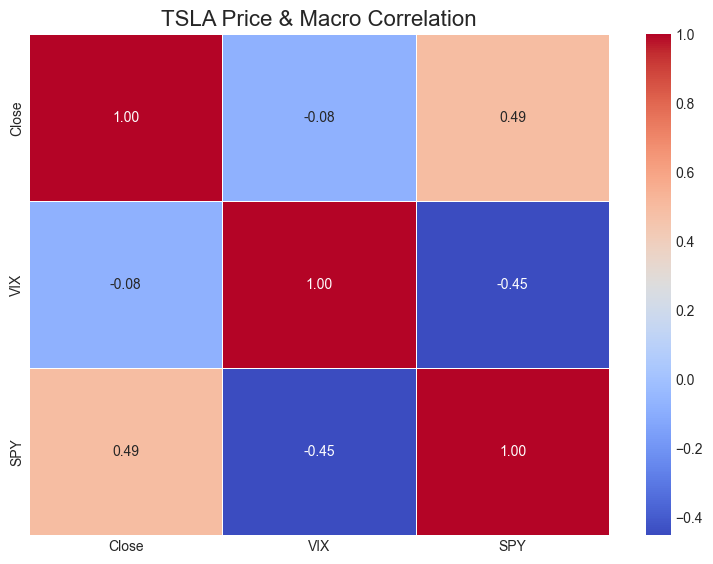

Saved plot: eda_plots/TSLA_price_macro_correlation.png

[E] Correlation Matrix (Stock Returns vs Macro Changes/Changes):
VIX_Change   -0.423862
SPY_Change    0.556265
------------------------------

[F] Comprehensive Correlation Matrix (All Features):


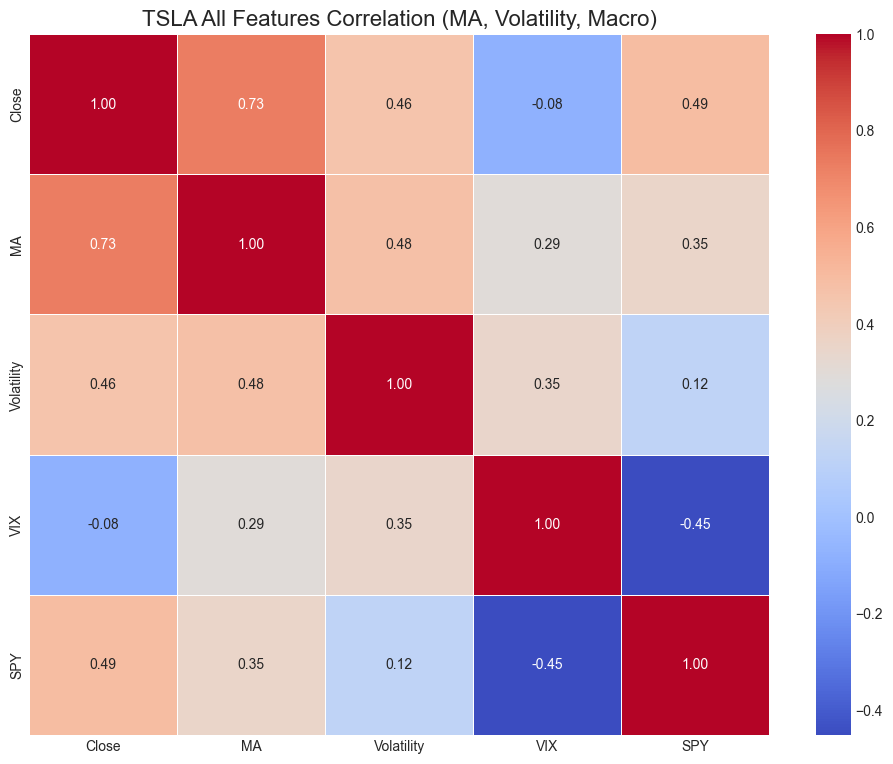

Saved plot: eda_plots/TSLA_all_features_correlation.png

[STEP 3: SEQUENTIAL MODELING AND EVALUATION]
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
dict_keys(['lr_rf_init', 'lstm_init', 'wfv_source', 'wfv_start_index', 'arima', 'plot_data'])

-- 3.1: Running LR Baseline (WFV) --
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating f

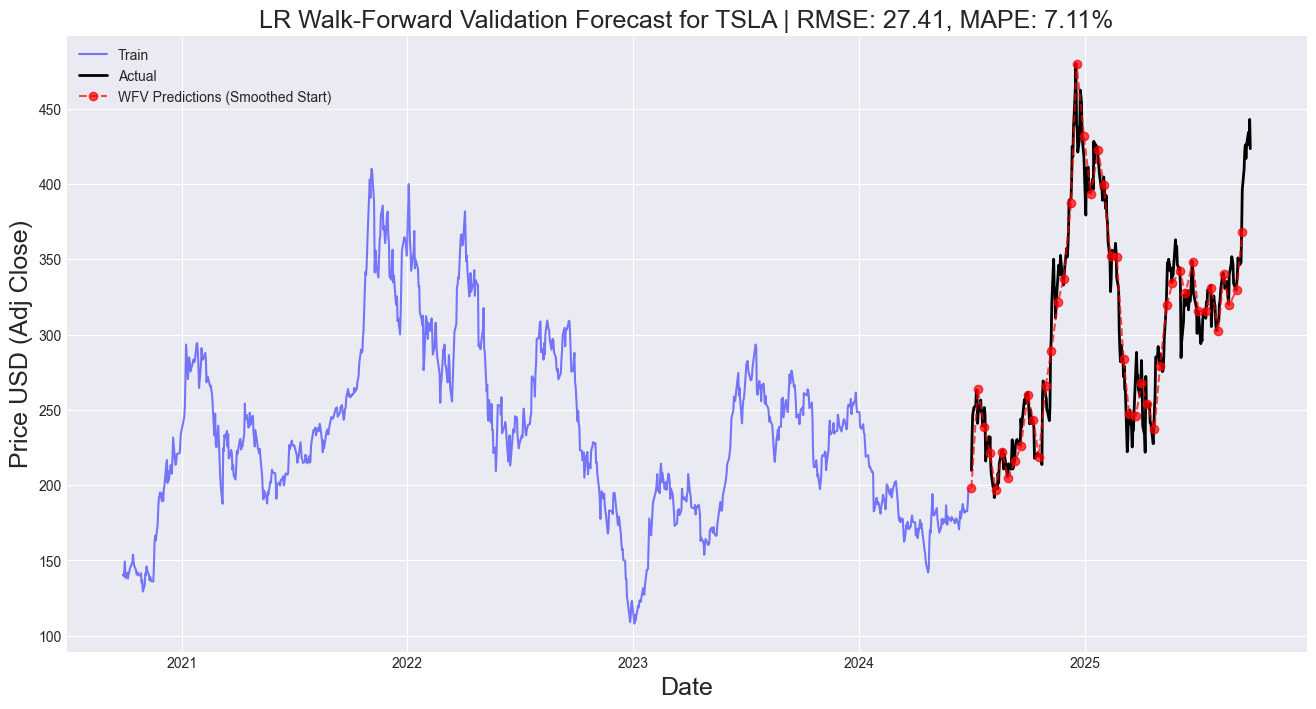

Saved plot: eda_plots/TSLA_lr_wfv_forecast.png
LR Baseline WFV RMSE: 27.41 | MAPE: 7.11%


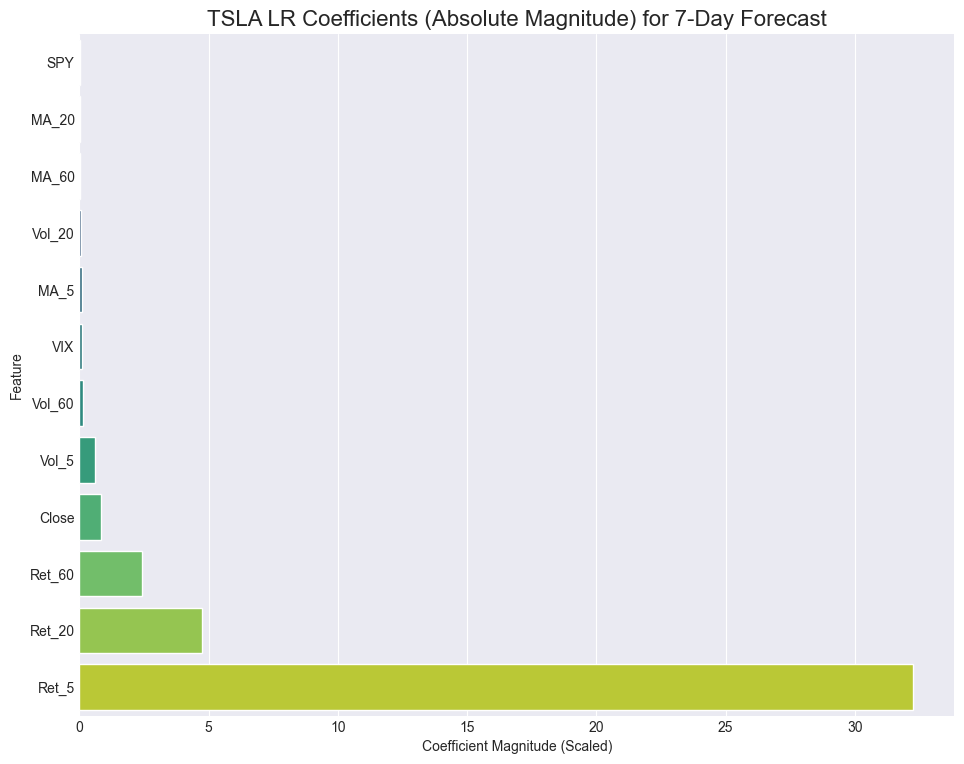

Saved plot: eda_plots/TSLA_lr_feature_importance.png

-- 3.2: Running Random Forest Improvement (WFV) --
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.
Creating feat

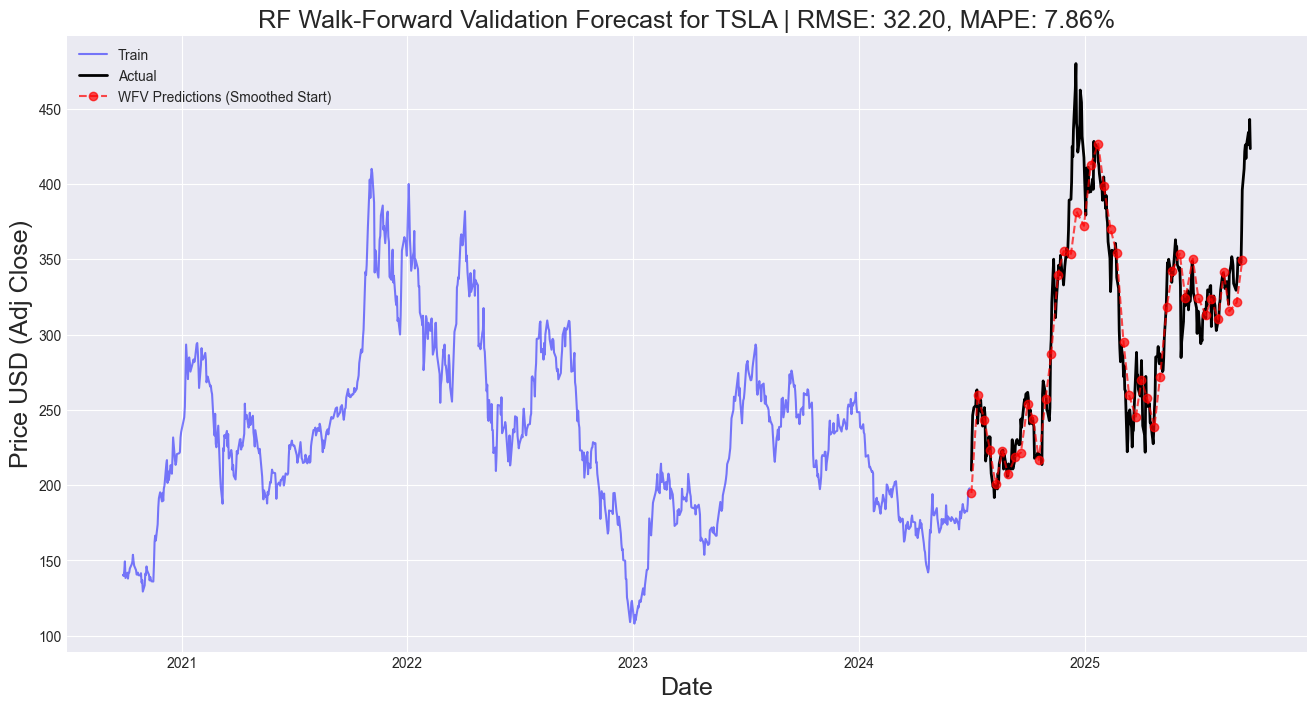

Saved plot: eda_plots/TSLA_rf_wfv_forecast.png
RF Improvement WFV RMSE: 32.20 | MAPE: 7.86%


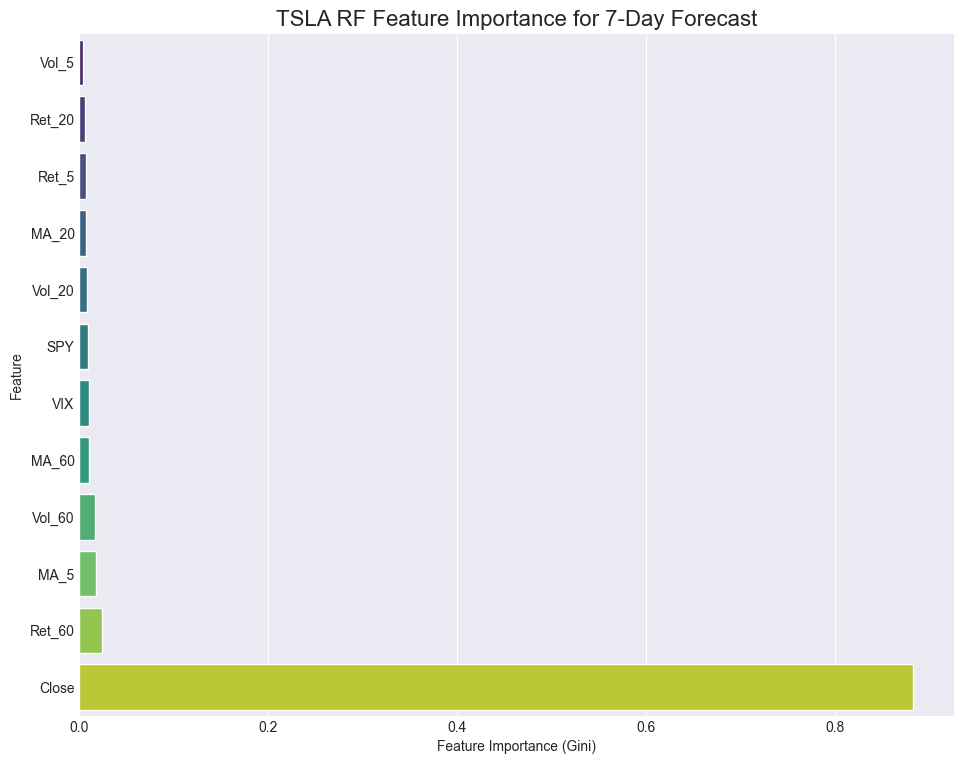

Saved plot: eda_plots/TSLA_rf_feature_importance.png

-- 3.3: Running ARIMA Improvement (WFV) --
ARIMA Improvement WFV RMSE: 16.84 | MAPE: 3.62%


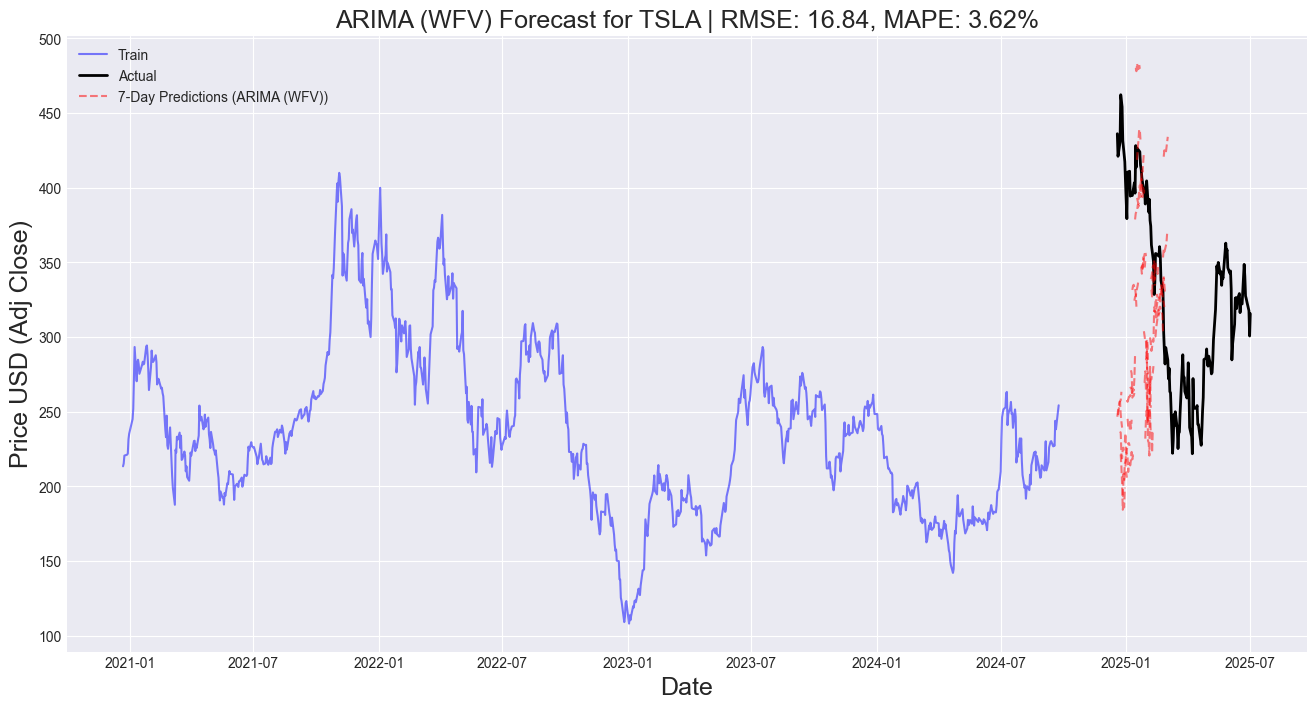

Saved plot: eda_plots/TSLA_arima (wfv)_forecast.png

-- 3.4: Running LSTM Deep Learning Improvement --
  [LSTM] Training Deep Learning Model (Epochs=100 with Early Stopping)...
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 31.
LSTM Improvement RMSE: 97.54 | MAPE: 29.69%


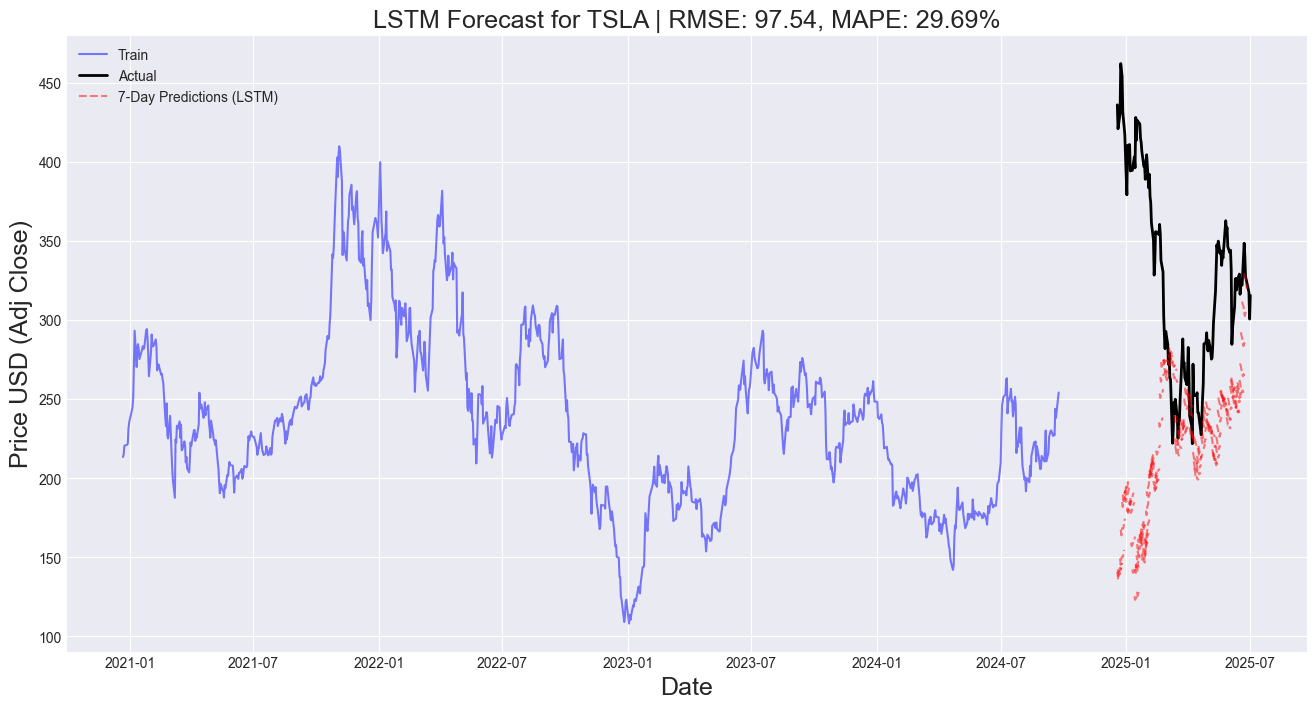

Saved plot: eda_plots/TSLA_lstm_forecast.png
--- TSLA WORKFLOW COMPLETE ---

[STEP 4: SAVING FINAL RESULTS]
All model results saved to: results/multi_model_comparison_results.csv

Final Summary Dashboard saved to: results/final_dashboard.md

Review the final_dashboard.md file for project conclusions.


In [84]:
# MAIN CODE BLOCK FOR EXECUTION

print("\n--- STARTING FULL STOCK ANALYSIS PIPELINE ---")
all_results = {}

for ticker in STOCK_TICKERS:
    try:
        print(f"\n#####################################################")
        print(f"### PROCESSING FULL WORKFLOW FOR {ticker} ###")
        print(f"#####################################################")
        
        # 1. DATA ACQUISITION AND MACRO DATA INTEGRATION
        print("\n[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]")
        df = get_stock_data(ticker, START_DATE, END_DATE)
   
        
        if df is None:
            # Note: get_stock_data now raises FileNotFoundError if file is missing
            print(f"Skipping {ticker} due to data acquisition failure.")
            continue

        df_processed = add_macro_features(df)

        # 2. EDA AND VISUALIZATION
        print("\n[STEP 2: EDA AND VISUALIZATION]")
        # Perform EDA and get the cleaned DataFrame back
        df_cleaned_for_modeling = perform_eda(df_processed.copy(), ticker)
        
        # Force process events before moving to next ticker (for sequential plotting)
        plt.pause(0.1) 

        # 3. MODELING AND EVALUATION (Sequential Improvement)
        print("\n[STEP 3: SEQUENTIAL MODELING AND EVALUATION]")
        
        # Prepare all necessary datasets once for the different models
        data_sets = get_train_test_sets(df_cleaned_for_modeling)

        print(data_sets.keys())
        
        ticker_metrics = {}

        # 3.1. Linear Regression (Baseline) 
        print("\n-- 3.1: Running LR Baseline (WFV) --")
        ticker_metrics.update(run_lr_baseline(data_sets, ticker))

        # 3.2. Random Forest (Tree-based Improvement) 
        print("\n-- 3.2: Running Random Forest Improvement (WFV) --")
        ticker_metrics.update(run_rf_model(data_sets, ticker))
        
        # 3.3. ARIMA (Statistical Time-Series Improvement) 
        print("\n-- 3.3: Running ARIMA Improvement (WFV) --")
        ticker_metrics.update(run_arima_model(data_sets, ticker))
        
        # 3.4. LSTM (Deep Learning Improvement) 
        print("\n-- 3.4: Running LSTM Deep Learning Improvement --")
        ticker_metrics.update(run_lstm_model(data_sets, ticker))
        
        all_results[ticker] = ticker_metrics
        
        print(f"--- {ticker} WORKFLOW COMPLETE ---")

    except FileNotFoundError as e:
        print(f"\nCRITICAL ERROR: Data cache failed for {ticker}. {e}")
        print("Please ensure all stock and macro CSV files exist in the 'stock_data' directory.")
    except Exception as e:
        print(f"\nFATAL ERROR during processing of {ticker}: {e}")
        print("Skipping remaining steps for this ticker.")
        
# --- FINAL RESULTS SAVING (ALWAYS RUNS) ---
##finally:
    print("\n[STEP 4: SAVING FINAL RESULTS]")
    
    # Function to generate the final Markdown summary dashboard
    def generate_final_summary_report(all_results):
        summary_path = os.path.join(RESULTS_DIR, 'final_dashboard.md')
        
        # Convert results dictionary to DataFrame for easy analysis
        flat_list = []
        for ticker, model_metrics in all_results.items():
            for model_name, (rmse, mape) in model_metrics.items():
                flat_list.append({
                    'Ticker': ticker,
                    'Model': model_name,
                    'RMSE': rmse,
                    'MAPE': mape
                })
        results_df = pd.DataFrame(flat_list)

        markdown_output = ["# Multi-Model Stock Prediction Final Dashboard\n"]
        markdown_output.append(f"Date Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        markdown_output.append("---")
        
        # 1. RMSE/MAPE Leaderboard (Overall)
        markdown_output.append("## Overall Performance Leaderboard (Lowest MAPE is Best)")
        
        # Find best overall model by MAPE
        leaderboard = results_df.sort_values(by='MAPE').reset_index(drop=True)
        markdown_output.append(leaderboard.to_markdown(index=False, floatfmt=".2f"))
        markdown_output.append("\n")

        # 2. Best Model Per Ticker
        markdown_output.append("## Best Performing Model Per Stock")
        
        best_per_ticker = results_df.loc[results_df.groupby('Ticker')['MAPE'].idxmin()]
        best_per_ticker = best_per_ticker[['Ticker', 'Model', 'MAPE', 'RMSE']]
        
        for index, row in best_per_ticker.iterrows():
            ticker = row['Ticker']
            model = row['Model']
            
            # Use the WFV image path for LR, RF, ARIMA, and the standard path for LSTM
            image_suffix = '_wfv_forecast' if model != 'LSTM' else '_lstm_forecast'
            image_path = os.path.join(PLOTS_DIR, f'{ticker}_{model.lower()}{image_suffix}.png')

            markdown_output.append(f"\n### {ticker}: **{model}** (MAPE: {row['MAPE']:.2f}%)")
            markdown_output.append(f"The **{model}** model provided the most accurate forecast for {ticker}.")
            markdown_output.append(f"Visualizing {model} Forecast:")
            markdown_output.append(f"![{ticker} Best Model Forecast]({image_path})")
        
        # 3. Forecast Image Paths
        markdown_output.append("\n---")
        markdown_output.append("## Forecast and Feature Importance Artifacts")
        markdown_output.append("All visual artifacts are saved in the `eda_plots` directory.")
        markdown_output.append("\n**Key Forecast Paths:**")
        
        for ticker in STOCK_TICKERS:
            markdown_output.append(f"* **{ticker} LR WFV Forecast:** `{os.path.join(PLOTS_DIR, f'{ticker}_lr_wfv_forecast.png')}`")
            markdown_output.append(f"* **{ticker} RF Feature Importance:** `{os.path.join(PLOTS_DIR, f'{ticker}_rf_feature_importance.png')}`")
            markdown_output.append(f"* **{ticker} LSTM Forecast:** `{os.path.join(PLOTS_DIR, f'{ticker}_lstm_forecast.png')}`")
        
        with open(summary_path, 'w') as f:
            f.write('\n'.join(markdown_output))
        
        print(f"\nFinal Summary Dashboard saved to: {summary_path}")
        print("\nReview the final_dashboard.md file for project conclusions.")

    # Save final CSV
    final_metrics_list = []
    for ticker, model_metrics in all_results.items():
        for model_name, (rmse, mape) in model_metrics.items():
            final_metrics_list.append({
                'Ticker': ticker,
                'Model': model_name,
                'RMSE': rmse,
                'MAPE': mape
            })

    results_df = pd.DataFrame(final_metrics_list)
    results_filepath = os.path.join(RESULTS_DIR, 'multi_model_comparison_results.csv')
    results_df.to_csv(results_filepath, index=False)
    print(f"All model results saved to: {results_filepath}")
    
    # Auto-generate Markdown Summary
    generate_final_summary_report(all_results)


In [82]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.
